# Prepraring the interactome inference

---

This notebook will be used to set the stage for the inference of the cell type specific interactome. To this end, we will be analyzing data from a scRNA-seq study, bulk sequencing data from the CCLE data set, curated gene sets e.g. from the Reactome data base and protein-protein interaction data curated in the iRefIndex data base. Additionally, we will use information regarding the specificity of the genes targeted in the overexpression study by Rohban et al. (2017). Such information are derived from preceeding analyses working on the imaging data. We will explain the used data sets further at a later stage.

---

## 0. Environmental setup

In [41]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_unweighted
import venn
import networkx as nx
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_1samp, pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import mutual_info_score
import matplotlib.cm as cm
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 600

import sys

sys.path.append("../../..")

from src.utils.notebooks.ppi.preprocessing import *

seed = 1234

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---

## 1. Read in data

We will read in a number of different data sets that we will use for our analyses: a) the single-cell gene expression data from Mahdessian et al. (2021), b) the most recent version of the CCLE expression data set, c) the list of ORF gene targets from the study by Rohban et al. (2017) and finally d) the Human PPI network as defined by the iRefIndexDB v14, e) a number of curated gene sets and f) the results of our image-based preceeding specificity screen.

The gene sets we read in are those describing the Reactome pathways related to the DNA damage repair, cell cycle, chromating organization as well as the list of human transcription factors and the set corresponding to the KEGG regulation of actin cytoskeleton pathway.

In [2]:
fucci_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
fucci_adata.var_names_make_unique()
fucci_data = pd.DataFrame(
    fucci_adata.X, columns=fucci_adata.var_names, index=fucci_adata.obs_names
)
fucci_data.columns = [c.upper() for c in fucci_data.columns]
fucci_data.head()

TSPAN6      DPM1     SCYL3  C1ORF112  CFH     FUCA2      GCLC  \
A10_355  4.084212  4.450537  2.539949  3.306074  0.0  3.924660  2.747193   
A10_356  4.416176  3.408068  0.000000  3.341437  0.0  3.109879  3.637463   
A10_357  2.784883  4.266762  0.000000  3.756405  0.0  4.676425  4.027002   
A11_355  3.995154  4.196535  1.325398  3.543870  0.0  3.015254  3.015254   
A11_356  5.384314  3.358004  2.851447  2.519226  0.0  4.309559  3.807653   

             NFYA     STPG1    NIPAL3  ...  NOTCH2NLR  SPDYE14     DERPC  \
A10_355  3.980721  3.192863  3.306074  ...   0.000000      0.0  0.000000   
A10_356  2.683064  2.919073  4.264037  ...   0.000000      0.0  2.540241   
A10_357  4.154050  3.560914  4.211993  ...   3.527433      0.0  3.144496   
A11_355  4.159373  0.000000  3.481722  ...   0.000000      0.0  3.219861   
A11_356  3.807653  3.843228  3.843228  ...   0.000000      0.0  3.926349   

          BMS1P23  LOC107986257  LOC728392  NOTCH2NLC   SPDYE11  \
A10_355  0.000000      0.000000        0.0   3.111745  0.000000   
A10_356  2.038441      1.584074        0.0   0.328890  1.336015   
A10_357  0.000000      0.000000        0.0   3.733050  0.000000   
A11_355  1.930217      0.000000        0.0   2.597980  1.435097   
A11_356  0.000000      0.000000        0.0   0.000000  1.948682   

         ARMCX5-GPRASP2  LOC114841035  
A10_355             0.0           0.0  
A10_356             0.0           0.0  
A10_357             0.0           0.0  
A11_355             0.0           0.0  
A11_356             0.0           0.0  

[5 rows x 21445 columns]

<IPython.core.display.Javascript object>

In [3]:
fucci_gene_set = set(fucci_data.columns)

<IPython.core.display.Javascript object>

The single-cell gene expression data from Mahdessian et al. (2021) to which we in the following refer to as FUCCI data set consists of 1'126 cells a 21'445.

In [4]:
ccle_data = pd.read_csv("../../../data/gex/ccle/CCLE_expression.csv", index_col=0)
ccle_sample_info = pd.read_csv(
    "../../../data/gex/ccle/CCLE_expression_sample_info.csv", index_col=0
)
matched_ids = set(ccle_sample_info.index).intersection(ccle_data.index)
ccle_data = ccle_data.loc[list(matched_ids)]
ccle_data.index = ccle_sample_info.loc[ccle_data.index, "stripped_cell_line_name"]
ccle_data.columns = [c.split(" ")[0].upper() for c in ccle_data.columns]
ccle_data.head()

TSPAN6  TNMD      DPM1     SCYL3  C1ORF112  \
stripped_cell_line_name                                                 
SW403                    4.699330   0.0  7.401306  3.279471  3.731183   
SNU878                   4.753818   0.0  6.463034  2.664483  3.840967   
PECAPJ15                 4.916954   0.0  6.331992  2.195348  3.498251   
JM1                      0.310340   0.0  6.690138  3.145677  5.204376   
NCIH1568                 5.626439   0.0  6.855242  2.185867  4.079805   

                              FGR       CFH     FUCA2      GCLC      NFYA  \
stripped_cell_line_name                                                     
SW403                    1.077243  0.367371  6.487036  5.497293  4.595146   
SNU878                   0.056584  6.363697  7.396434  6.079378  4.055716   
PECAPJ15                 0.321928  3.192194  6.561479  4.543496  3.418190   
JM1                      2.613532  0.014355  0.250962  5.061344  5.654779   
NCIH1568                 0.084064  0.176323  6.824513  4.956521  3.766595   

                         ...  ARHGAP11B  AC004593.2  AC090517.4  AL160269.1  \
stripped_cell_line_name  ...                                                  
SW403                    ...   1.664483    0.263034    0.000000    0.000000   
SNU878                   ...   2.266037    0.000000    0.084064    0.855990   
PECAPJ15                 ...   1.521051    0.286881    0.070389    1.042644   
JM1                      ...   1.709291    0.000000    0.028569    0.000000   
NCIH1568                 ...   1.985500    0.189034    0.097611    0.238787   

                         ABCF2-H2BE1   POLR2J3    H2BE1  AL445238.1  \
stripped_cell_line_name                                               
SW403                       3.587365  5.313609  0.00000    0.000000   
SNU878                      3.238787  5.383704  0.00000    0.687061   
PECAPJ15                    1.144046  5.660780  0.00000    0.000000   
JM1                         3.659925  6.281698  0.15056    0.000000   
NCIH1568                    1.405992  6.418865  0.00000    0.000000   

                         GET1-SH3BGR  AC113348.1  
stripped_cell_line_name                           
SW403                       0.000000         0.0  
SNU878                      0.000000         0.0  
PECAPJ15                    0.070389         0.0  
JM1                         0.238787         0.0  
NCIH1568                    0.536053         0.0  

[5 rows x 19177 columns]

<IPython.core.display.Javascript object>

In [5]:
ccle_gene_set = set(ccle_data.columns)

<IPython.core.display.Javascript object>

The second data set from the CCLE study consist of 1'378 cancer cell lines for which we obtain the expression of roughly 19'177 genes.

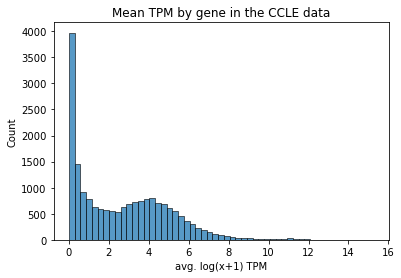

<IPython.core.display.Javascript object>

In [6]:
ax = sns.histplot(ccle_data.mean())
ax.set_xlabel("avg. log(x+1) TPM")
ax.set_title("Mean TPM by gene in the CCLE data")
plt.show()

Next, we load the previously mentioned gene sets.

In [7]:
cell_cycle_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/reactome_cell_cycle.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [8]:
chrom_org_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/reactome_chrom_org.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [9]:
dna_repair_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/reactome_dna_repair.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [10]:
reg_actin_cytoskeleton_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/kegg_reg_act_cytoskeleton.txt",
        index_col=0,
        header=None,
    ).index
)

<IPython.core.display.Javascript object>

In [11]:
human_tfs = set(
    list(
        pd.read_csv(
            "../../../data/other/genesets/human_tf_list.txt", index_col=0, header=None
        ).index
    )
)

<IPython.core.display.Javascript object>

In [12]:
l1000_genes = set(
    list(
        pd.read_csv(
            "../../../data/other/genesets/l1000.txt", index_col=0, header=None
        ).index
    )
)

<IPython.core.display.Javascript object>

In [13]:
specificity_screen_results = pd.read_csv(
    "../../../data/other/specificity_results/specificity_screen_results_cv.csv",
    index_col=0,
)
specificity_screen_results.head()

train_loss  val_loss  test_loss  train_acc   val_acc  test_acc  \
target                                                                   
ACVR1B    0.544189  0.833747   0.840600   0.691729  0.546542  0.535706   
ADAM17    0.491044  0.895316   0.840601   0.760460  0.520837  0.537946   
AKT1      0.464380  0.738612   0.757043   0.748430  0.666825  0.638988   
AKT1S1    0.255587  0.619633   0.727752   0.892443  0.749870  0.707755   
AKT2      0.534798  0.614510   0.714037   0.712890  0.698162  0.605114   

        train_bacc  val_bacc  test_bacc  mean_balanced_accuracy  \
target                                                            
ACVR1B    0.692468  0.542970   0.535460                0.535460   
ADAM17    0.760125  0.545684   0.539397                0.539397   
AKT1      0.748774  0.665762   0.638762                0.638762   
AKT1S1    0.892200  0.750665   0.707602                0.707602   
AKT2      0.717228  0.685532   0.608857                0.608857   

        rohban_selected  mechano_pathways  selected  
target                                               
ACVR1B            False             False     False  
ADAM17            False             False     False  
AKT1               True              True     False  
AKT1S1             True             False      True  
AKT2              False              True     False

<IPython.core.display.Javascript object>

In [14]:
specific_targets = set(
    specificity_screen_results.loc[specificity_screen_results["selected"] == True].index
)

<IPython.core.display.Javascript object>

Finally we load the human PPI as curated in the iRefIndexDB v14.

In [15]:
ppi_file = "../../../data/ppi/input/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
iref_ppi = nx.convert_matrix.from_pandas_edgelist(
    pd.read_csv(ppi_file, sep="\t"),
    source="protein1",
    target="protein2",
    edge_attr="cost",
)
iref_ppi.remove_edges_from(nx.selfloop_edges(iref_ppi))
iref_ppi.name = "human PPI"

<IPython.core.display.Javascript object>

In [16]:
for edge in iref_ppi.edges(data=True):
    edge[-1]["mi_score"] = edge[-1]["cost"]

<IPython.core.display.Javascript object>

In [17]:
ppi_gene_set = set(list(iref_ppi.nodes()))

<IPython.core.display.Javascript object>

In [18]:
print(nx.info(iref_ppi))

Graph named 'human PPI' with 15759 nodes and 181955 edges


<ipython-input-18-baef3596decf>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(iref_ppi))


<IPython.core.display.Javascript object>

The network consists of 15'759 nodes and 181'955 edges with an average node degree of 23.0922.

---

## 2. Preliminary analyses

Next, we will analyze the data to i.a. define the gene set that we want to focus on in the remainder of the study.

The Venn diagram below shows the overlap of the two gene expression data sets with the 41 specific ORF targets from the study by Rohban et al. (2017) as well as with the ones from iRefIndexDB v14. That we will use later on as a basis to derive the interactome specific to the U2OS cells.

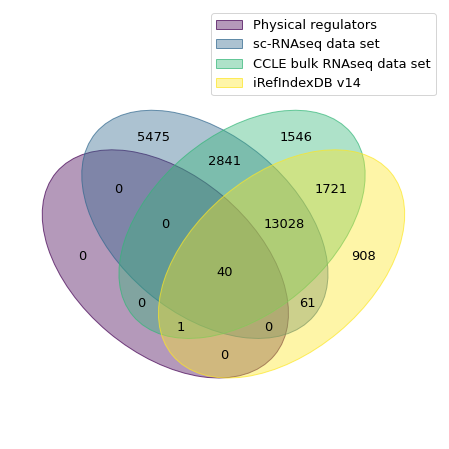

<IPython.core.display.Javascript object>

In [19]:
ax = venn.venn(
    dict(
        zip(
            [
                "Physical regulators",
                "sc-RNAseq data set",
                "CCLE bulk RNAseq data set",
                "iRefIndexDB v14",
            ],
            [
                specific_targets,
                fucci_gene_set,
                ccle_gene_set,
                ppi_gene_set,
            ],
        )
    )
)

Going forward, we will focus on the intersection of the genes that are covered in the scRNAseq (FUCCI) data set, the CCLE bulk RNAseq data set and the iRefIndexDB v14. We see that this will exclude one gene that we found to yield a specific and reproducible structural phenotype namely MOS.

In [20]:
selected_gene_set = fucci_gene_set.intersection(ppi_gene_set).intersection(
    ccle_gene_set
)
print(specific_targets - selected_gene_set)
specific_targets = specific_targets.intersection(selected_gene_set)

{'MOS'}


<IPython.core.display.Javascript object>

In [21]:
len(selected_gene_set)

13068

<IPython.core.display.Javascript object>

The selected gene set consists of 13'068 genes all of which are covered in either of the two RNAseq data sets, the human PPI and the CMAP signatures. We remove MOS from the set of specific ORF targets as the gene is not covered by the scRNA-seq data set or in the human PPI respectively. Thus 40 structural regulators remain.

---

## 2. Identification of U2OS gene set

In total we have 13'068 genes that we selected for further analyses. However, we have to yet identify those that are particularly important in the functional and thus regulatory programs of our cell type: human osteosarcoma (U2OS) cells.

### 2a. CCLE data marker screen

To identify the markers, we use the CCLE bulk RNAseq data set.
This data set provides the average expression for roughly 20'000 genes for 1'378 different cancer cell lines including U2OS cells.

Inspired by we identify those genes that are differentially expressed (regulated) in U2OS cells when comparing those to the background distribution from the remaining 1'377 cancer cell lines in the data set. To identify those we test for every gene if the mean expression of all other cancer cell lines is significantly different than the expression of that respective gene for U2OS cells using the bulk RNAseq data. In particular, we will test the following for each gene:

$$
H_A: \quad \bar{x}_i = x_{i,U2OS}, \quad \textrm{with} \ \bar{x}_i=\frac{1}{N-1}\sum\limits_{j\neq U2OS}x_{i,j}
$$
where $x_{i,j}$ is the transformed expression of gene $i$ in cell type $j$. Note that due to the large sample size we will assume the log-transformed gene expression for each gene to approximately follow a standard normal distribution. Thus, we will perform a one sample t-test to assess the significance of any under-or overexpression.

Note that we subset the gene set to those that are also present in both the scRNAseq data set and the human PPI.

In [22]:
ccle_data = ccle_data.loc[:, selected_gene_set]

<IPython.core.display.Javascript object>

In [23]:
marker_results = find_markers(
    ccle_data,
    target="U2OS",
    avg_log_fc=0.0,
    min_pct=0,
)

<IPython.core.display.Javascript object>

The table below shows the top 10 genes that show the largest absolute log-fold change when comparing U2OS cells vs. the other cancer cell lines of the CCLE data set.

In [24]:
marker_results.loc[(marker_results["fdr"] < 0.05)].sort_values(
    "abs_log_fc", ascending=False
).head(10)

log_expr_target  avg_log_expr_other    log_fc  abs_log_fc  pval  fdr
DHRS2         10.913937            2.265074  8.648862    8.648862   0.0  0.0
PAGE2          7.891055            0.447193  7.443861    7.443861   0.0  0.0
HAPLN1         7.514122            0.537060  6.977062    6.977062   0.0  0.0
KRT81          9.080338            2.109525  6.970813    6.970813   0.0  0.0
PCLO           8.285310            1.510797  6.774512    6.774512   0.0  0.0
KRT17          9.705892            2.965366  6.740525    6.740525   0.0  0.0
CXCL14         6.953382            0.699980  6.253402    6.253402   0.0  0.0
TNNC1          7.932451            1.779374  6.153077    6.153077   0.0  0.0
MAGEA1         7.011898            0.922583  6.089315    6.089315   0.0  0.0
KRT75          6.136068            0.190374  5.945694    5.945694   0.0  0.0

<IPython.core.display.Javascript object>

The absolute log-fold change for those roughly 13k genes exponentially decays with the maximum being 8.649. The figure below shows the absolute log-fold change for each gene in decreasing order.

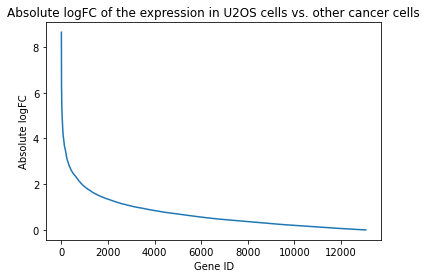

<IPython.core.display.Javascript object>

In [25]:
plt.figure()
plt.plot(
    list(range(len(marker_results))),
    np.array(
        marker_results.sort_values("abs_log_fc", ascending=False).loc[:, "abs_log_fc"]
    ),
)
plt.ylabel("Absolute logFC")
plt.xlabel("Gene ID")
plt.title("Absolute logFC of the expression in U2OS cells vs. other cancer cells")
plt.show()

In [26]:
sig_labels = []
for idx in marker_results.index:
    if (
        marker_results.loc[idx, "fdr"] > 0.0001
        or marker_results.loc[idx, "abs_log_fc"] < 0.0
    ):
        sig_labels.append("not DEGs")
    else:
        if marker_results.loc[idx, "log_fc"] > 0:
            sig_labels.append("up-regulated")
        else:
            sig_labels.append("down-regulated")
marker_results["sig_label"] = np.array(sig_labels)

<IPython.core.display.Javascript object>

In [37]:
marker_results.abs_log_fc.describe()

count    13068.000000
mean         0.735907
std          0.771739
min          0.000030
25%          0.213317
50%          0.498485
75%          0.985426
max          8.648862
Name: abs_log_fc, dtype: float64

<IPython.core.display.Javascript object>

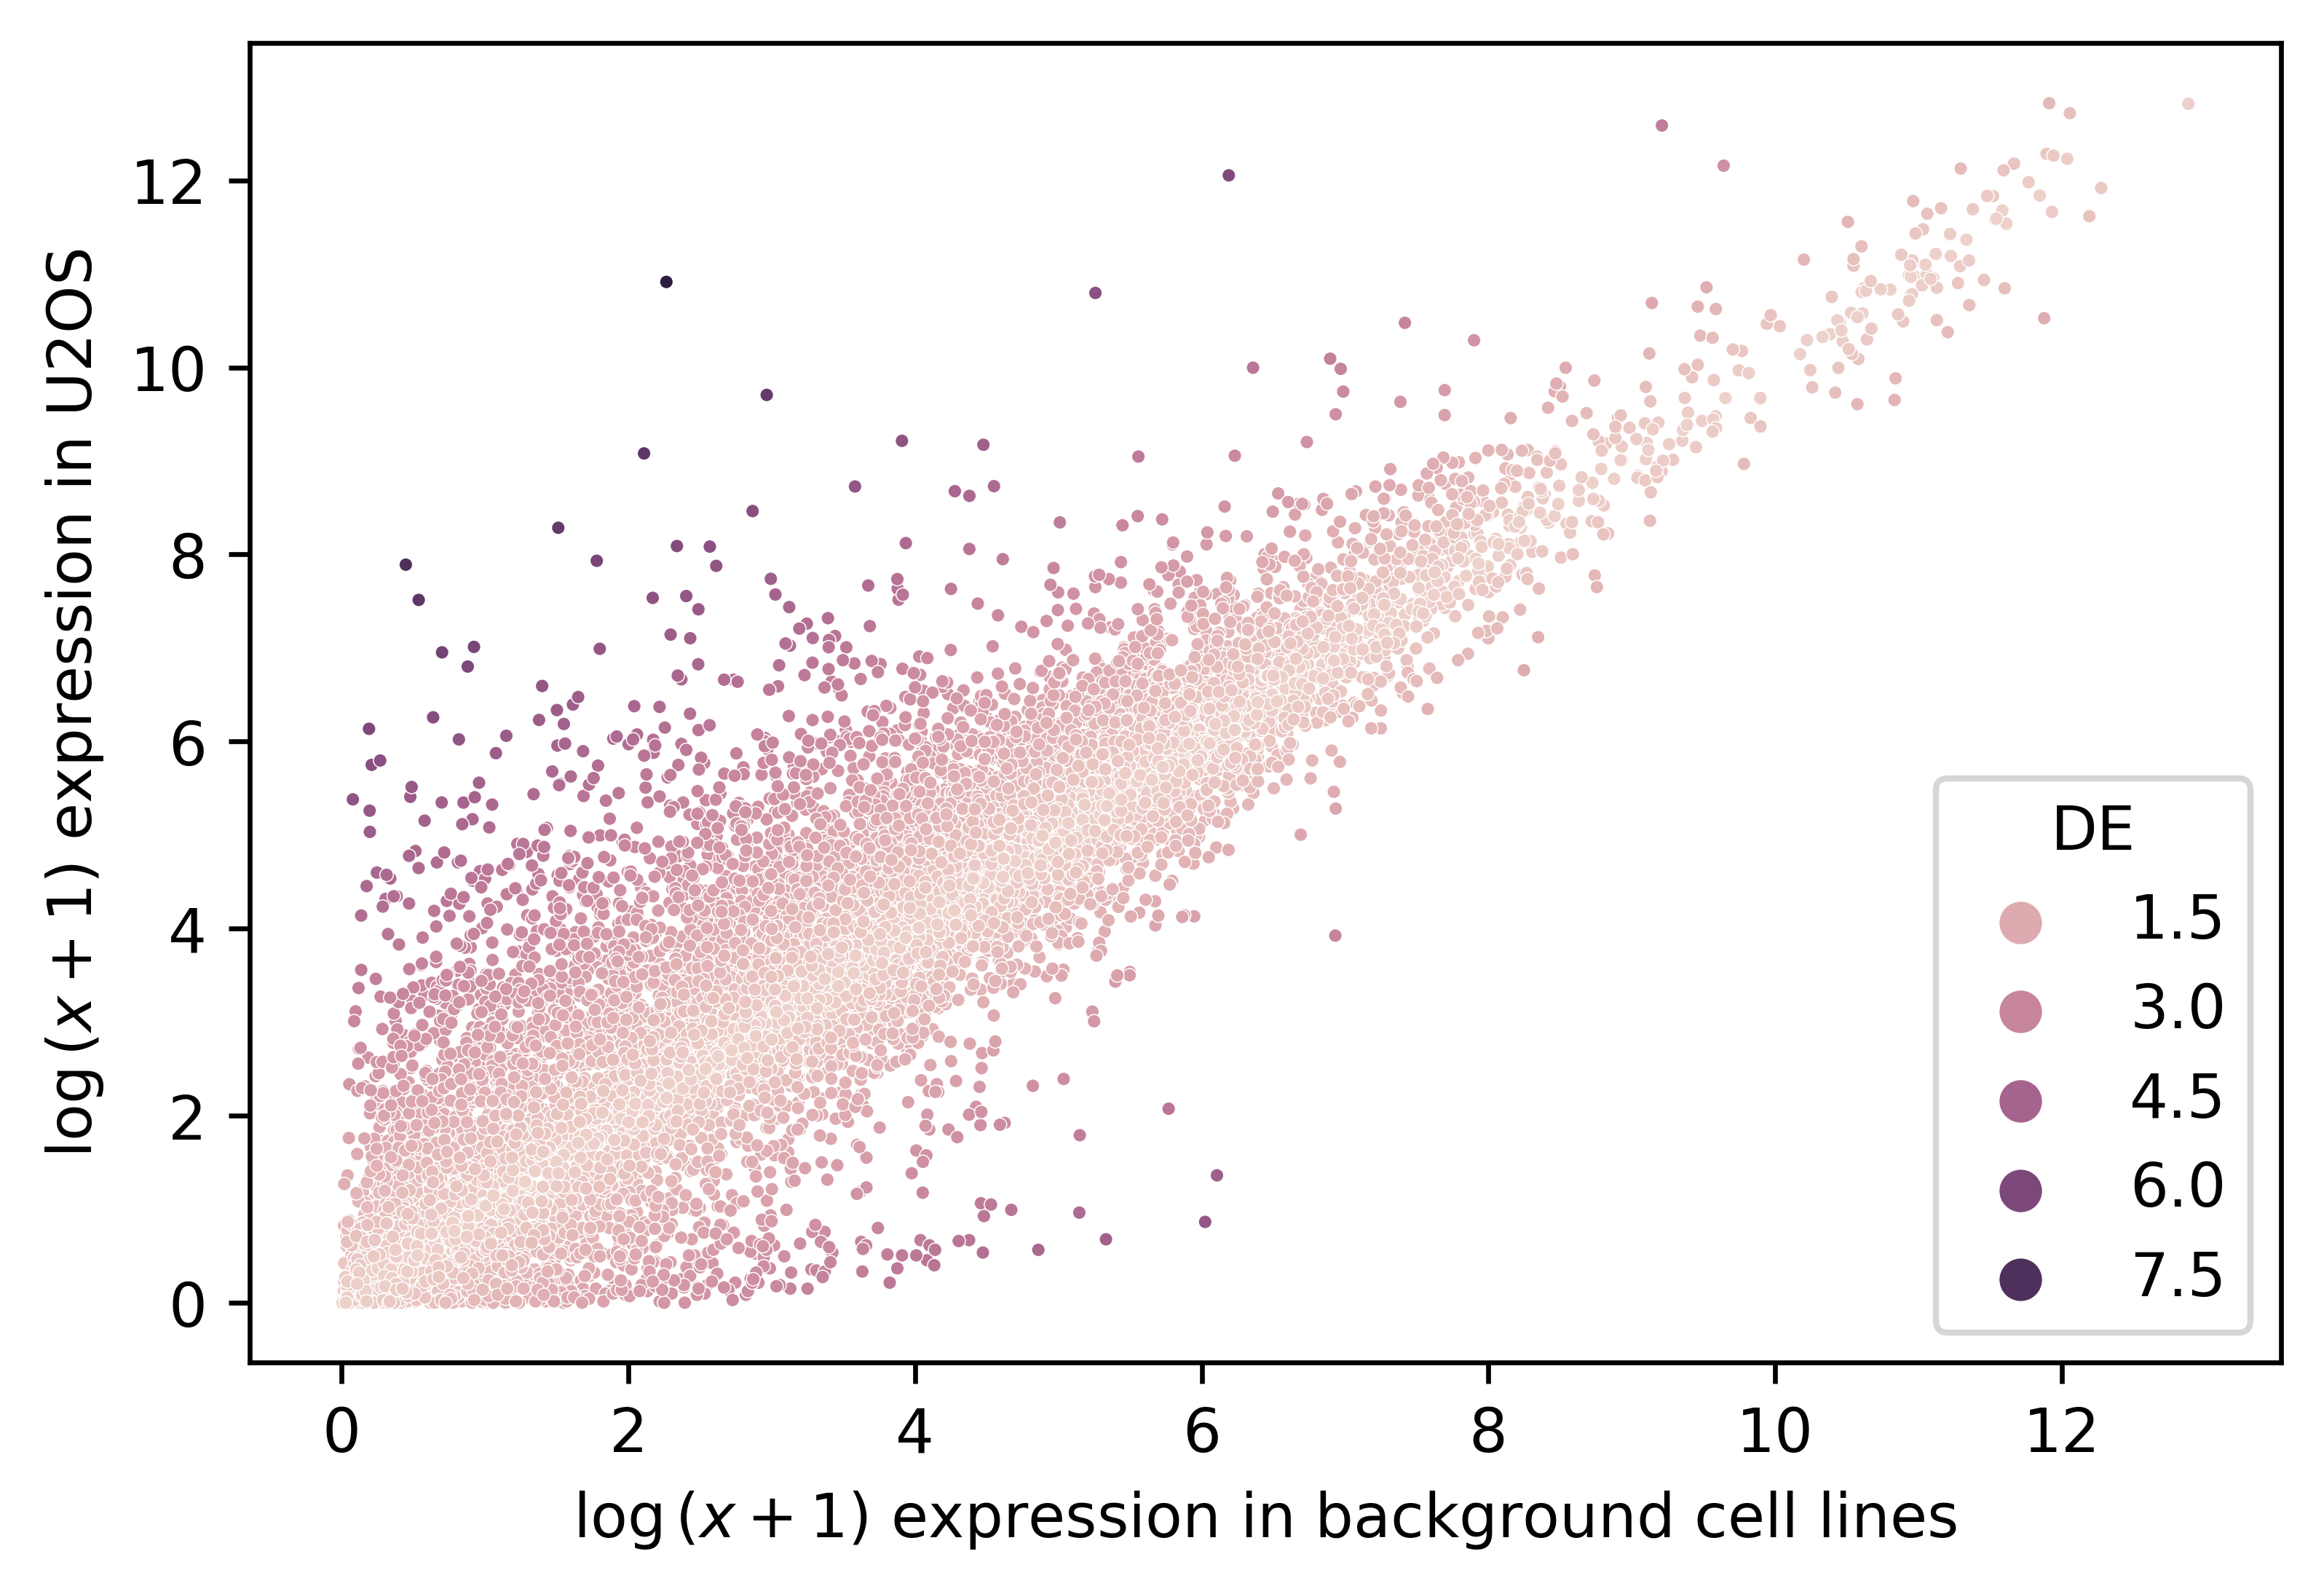

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.scatterplot(
    data=marker_results,
    x="avg_log_expr_other",
    y="log_expr_target",
    s=5,
    hue="abs_log_fc",
    #     palette={
    #         "up-regulated": "forestgreen",
    #         "not DEGs": "black",
    #         "down-regulated": "tab:red",
    #     },
    #     hue_order=["up-regulated", "not DEGs", "down-regulated"],
    cmap="green",
)
ax.legend(title="DE")
ax.set_ylabel(r"$\log{(x+1)}$ expression in U2OS")
ax.set_xlabel(r"$\log{(x+1)}$ expression in background cell lines")
plt.show()


---

### 2b. The specific ORF targets as U2OS marker

Next, we look a little bit more in depth at specific ORF target genes that we obtained from the data of the image-based over-expression screen by Rohban et al (2017). Those genes are of particular interest for our study. Please refer to the corresponding (screen analyses) notebook for further explanation on this step.

The plots below show the previously computed absolute log-fold change for the 41 remaining specific target genes.

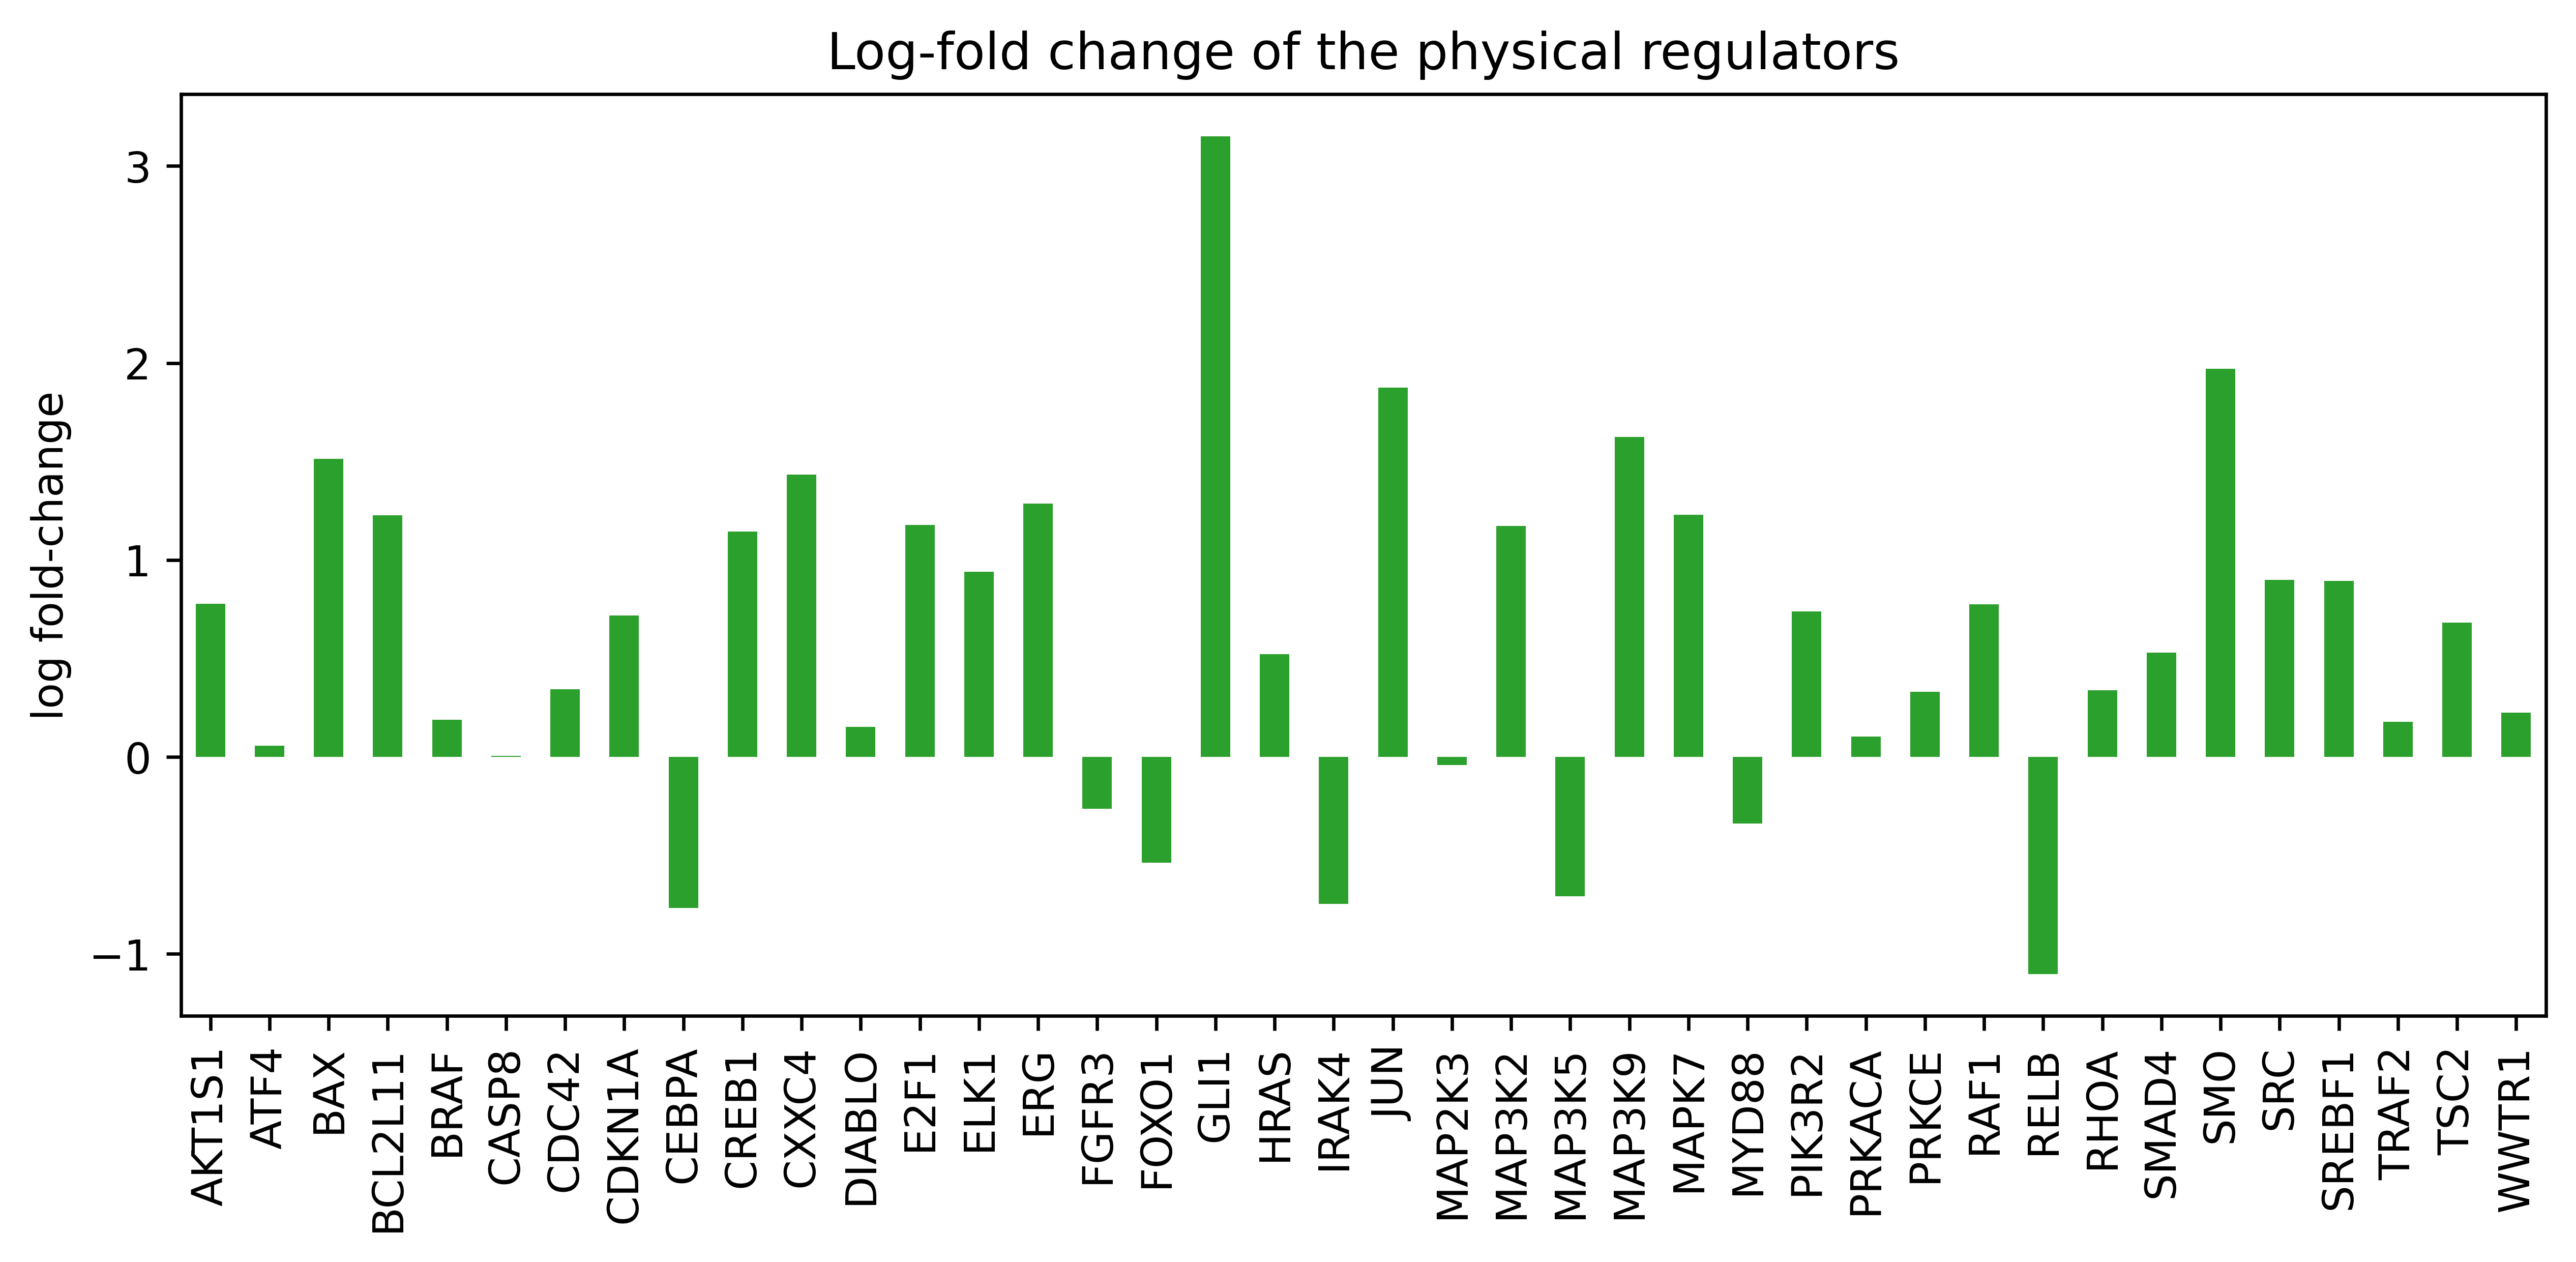

<IPython.core.display.Javascript object>

In [45]:
orf_log_fc = marker_results.loc[
    set(list(marker_results.index)).intersection(specific_targets), "log_fc"
]
orf_log_fc.sort_index().plot.bar(figsize=[10, 4], color="tab:green")
plt.ylabel("log fold-change")
plt.title("Log-fold change of the physical regulators")
plt.show()

Importantly, we see that many of the specific ORF targets are not strongly differentially regulated in U2OS cells when compared to other cancer cell lines. This also holds true for those target genes that yielded a specific structural phenotype upon overexpression in the image-based study such as e.g. JUN.

Nonetheless, we observe a quite heterogenous distribution of the absolute log-fold change for the individual ORF targets as also visualized in the histogram below.

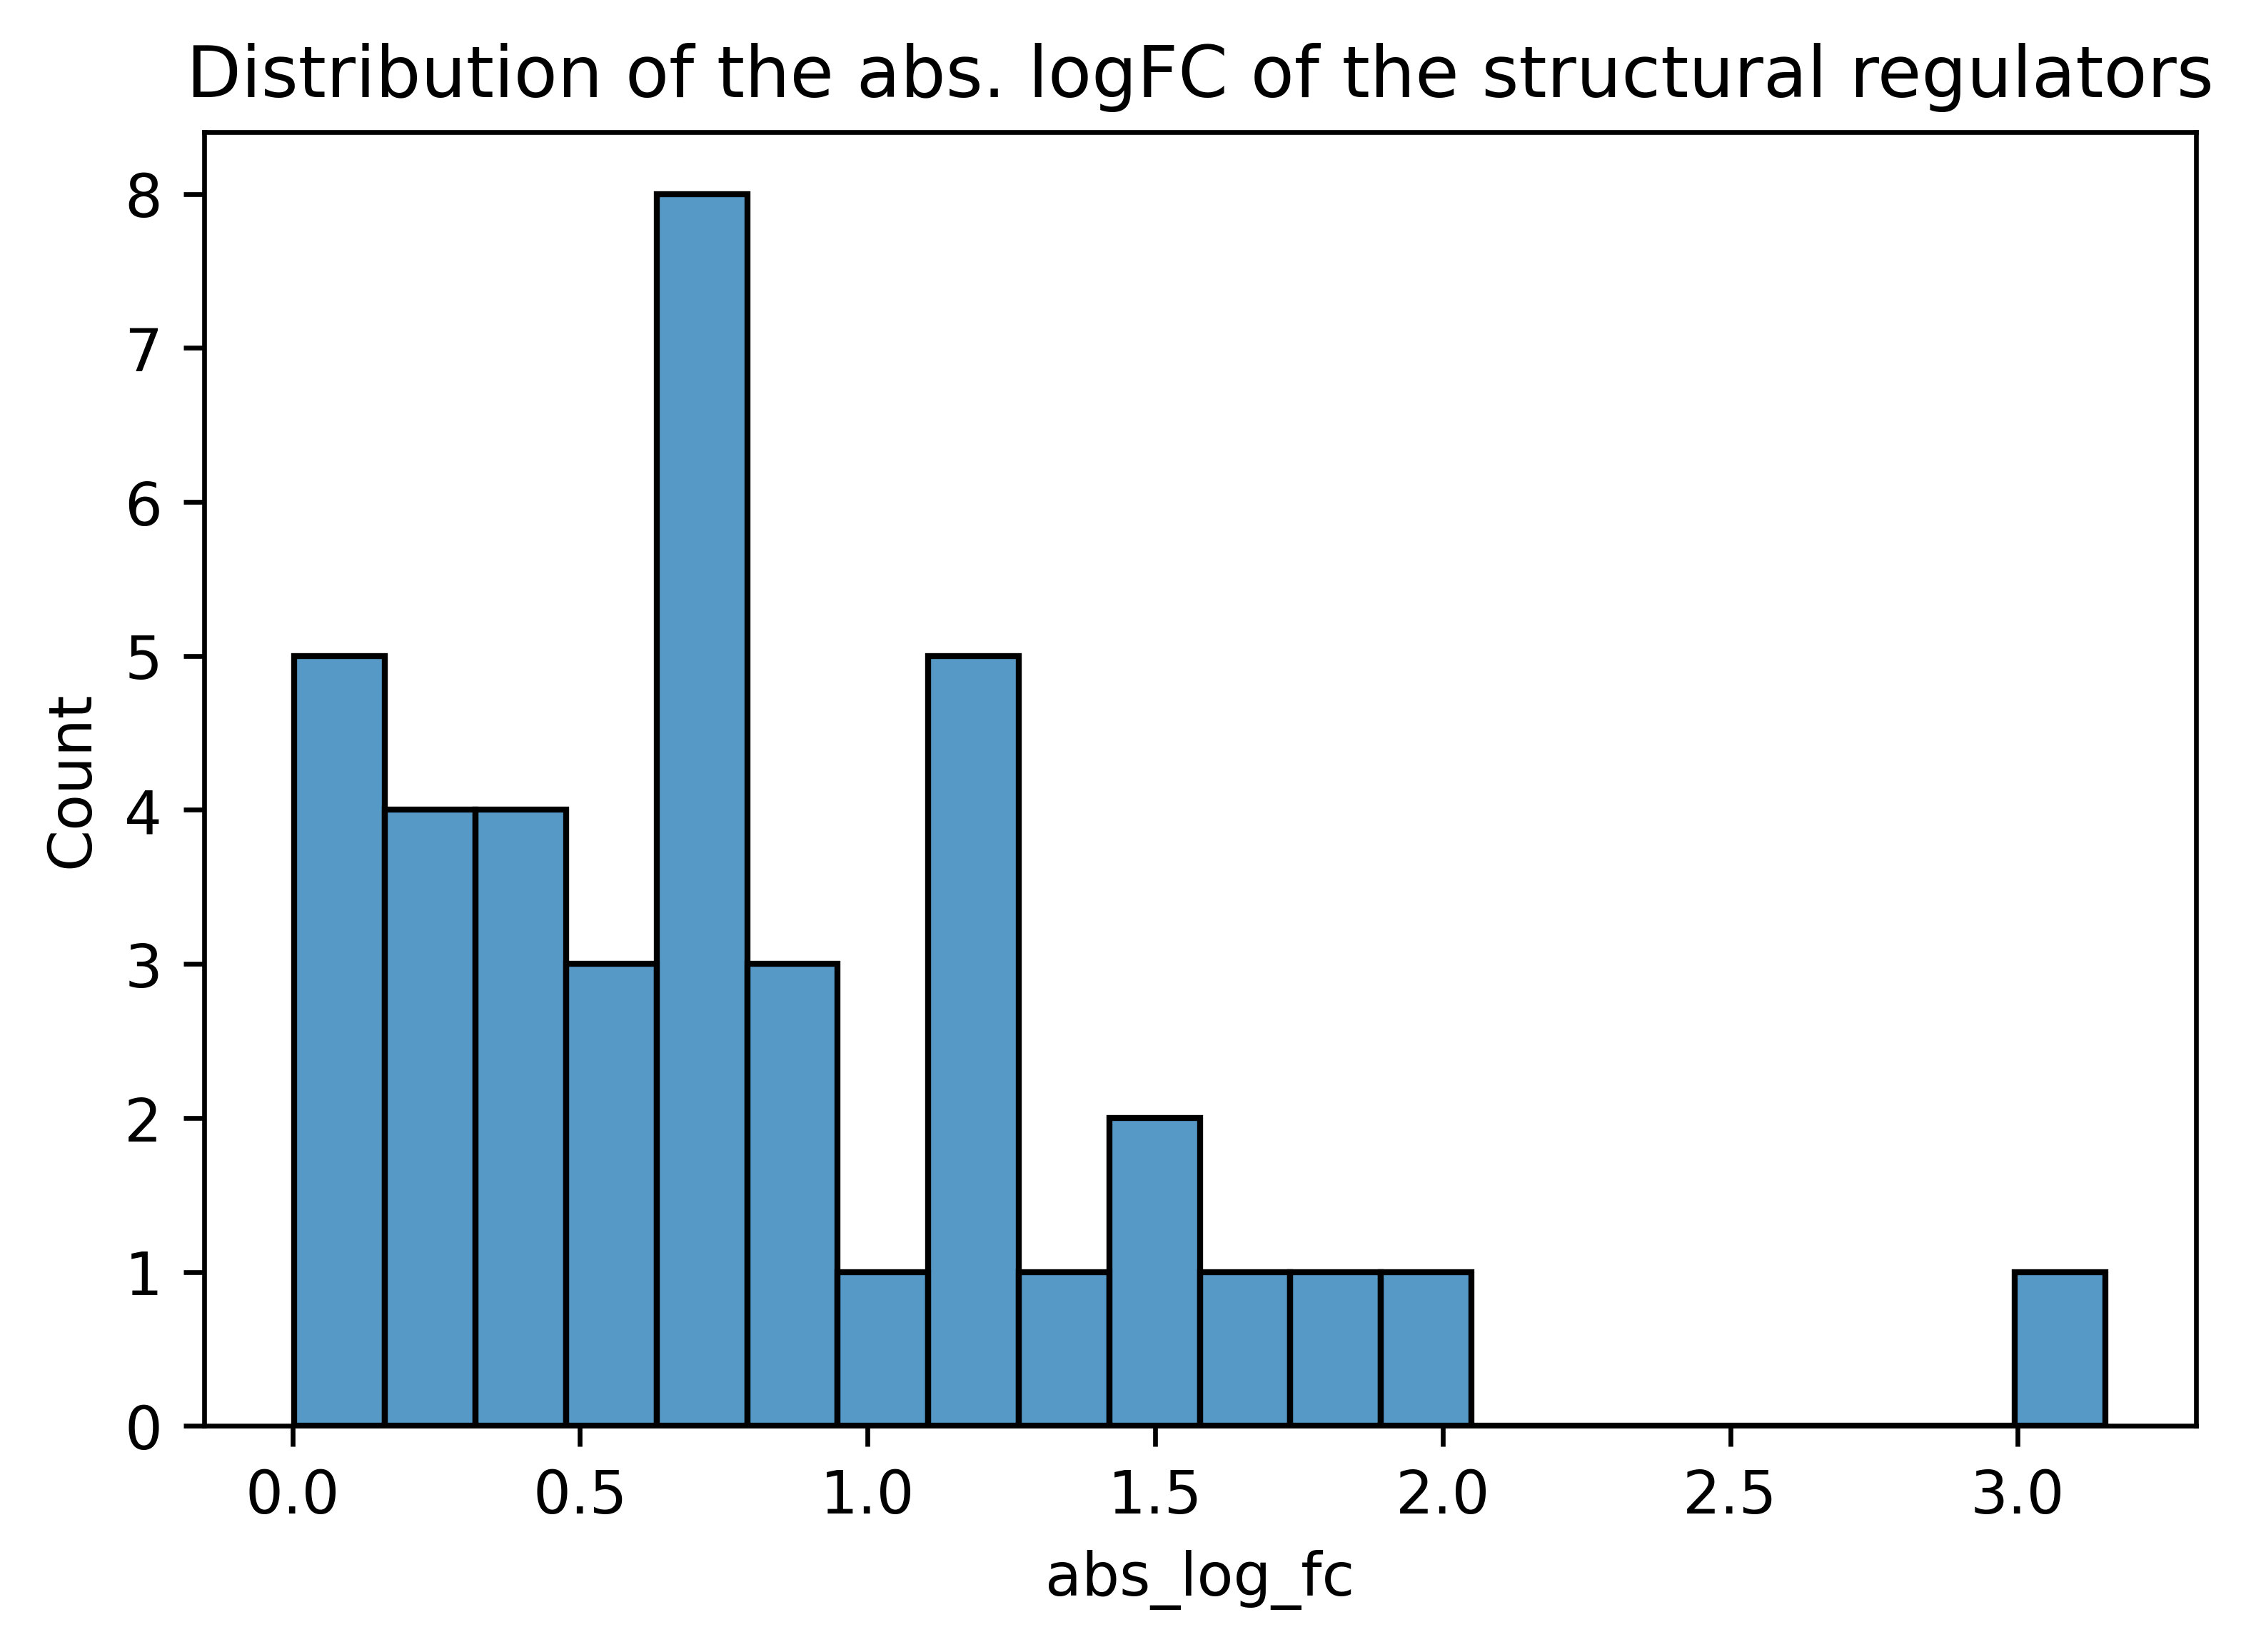

<IPython.core.display.Javascript object>

In [46]:
orf_abs_log_fc = marker_results.loc[specific_targets, "abs_log_fc"]
fig = plt.figure()
sns.histplot(data=orf_abs_log_fc, bins=20)
plt.title("Distribution of the abs. logFC of the structural regulators")
plt.show()

Importantly, with the exception of CEBPA, FGFR3 and MAP3K5 all of those genes are fairly high expressed in wild-type U2OS cells.

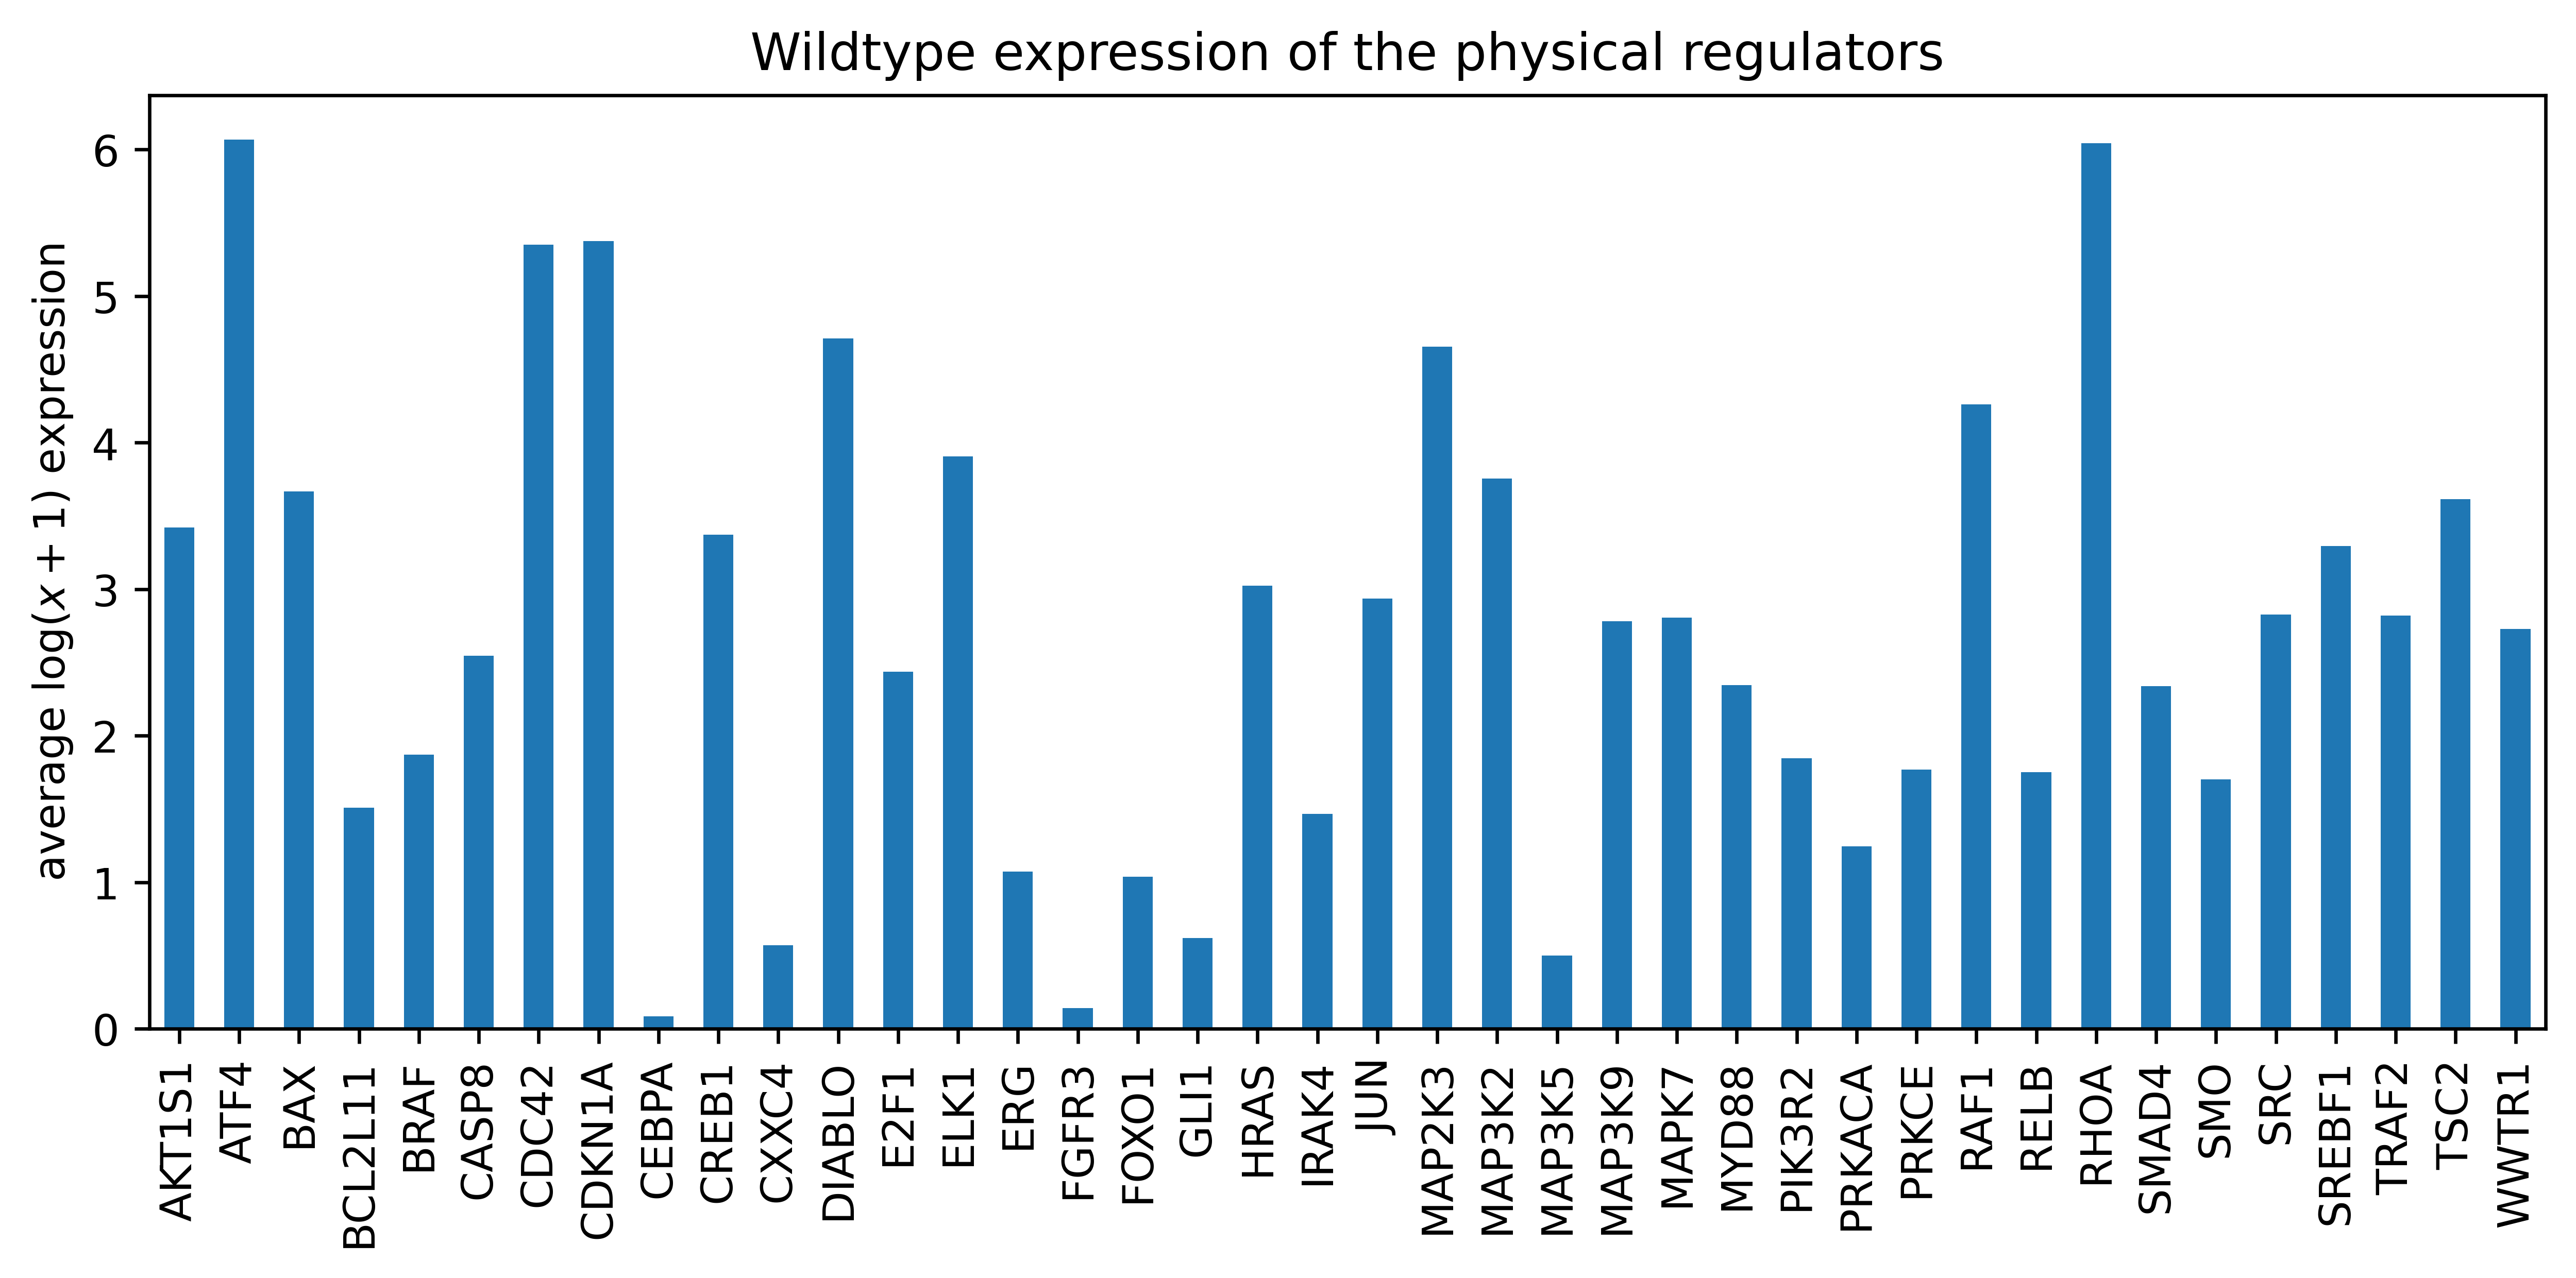

<IPython.core.display.Javascript object>

In [47]:
fucci_data.loc[:, sorted(set(specific_targets))].mean().plot.bar(figsize=[10, 4])
plt.ylabel(r"average $\log(x+1)$ expression")
plt.title("Wildtype expression of the physical regulators")
plt.show()

We will keep that in mind for later.

---

## 3. Preprocessing the PPI

After assessing the importance of each of the genes in our selected gene set as markers of U2OS cells when comparing them to other cancer cell lines, we will now turn to the human PPI. The human PPI as curated in the iRefIndex data base is constructed based on many different data sources and thus provides a rather general description of the interactive relationships of proteins respective the genes that code for those in human cell lines.

To derive a subnetwork that is specific to U2OS cells and well capture the specific regulatory relationships of our selected gene sets in those cells, we will perform a number of preprocessing steps. 


### 3.1. Remove uncovered genes

As an initial step we will focus on the subnetwork that we obtain by filtering out all genes that are not covered in both of the RNAseq data sets.

In [48]:
filtered_ppi = iref_ppi.subgraph(selected_gene_set)
filtered_ppi.name = "filtered PPI"
print(nx.info(filtered_ppi))

Graph named 'filtered PPI' with 13068 nodes and 153980 edges


<ipython-input-48-7c25221bf76f>:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(filtered_ppi))


<IPython.core.display.Javascript object>

The corresponding network consists of 13'068 nodes describing individual genes and 153'980 describing the interactive relationships between these genes.

Note that this splits the human PPI into 110 disconnected components. However importantly the largest connected component spans all ORF targets.

In [49]:
ccomps = [
    filtered_ppi.subgraph(c).copy() for c in nx.connected_components(filtered_ppi)
]
filtered_ppi = ccomps[0]

print(nx.info(filtered_ppi))

Graph named 'filtered PPI' with 12956 nodes and 153977 edges


<ipython-input-49-a3fcdbf9998c>:6: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(filtered_ppi))


<IPython.core.display.Javascript object>

In [50]:
np.mean(list(dict(filtered_ppi.degree()).values()))

23.76921889472059

<IPython.core.display.Javascript object>

This network consists of 12'956 nodes and 153'977 edges with an average degree of 23.77 .

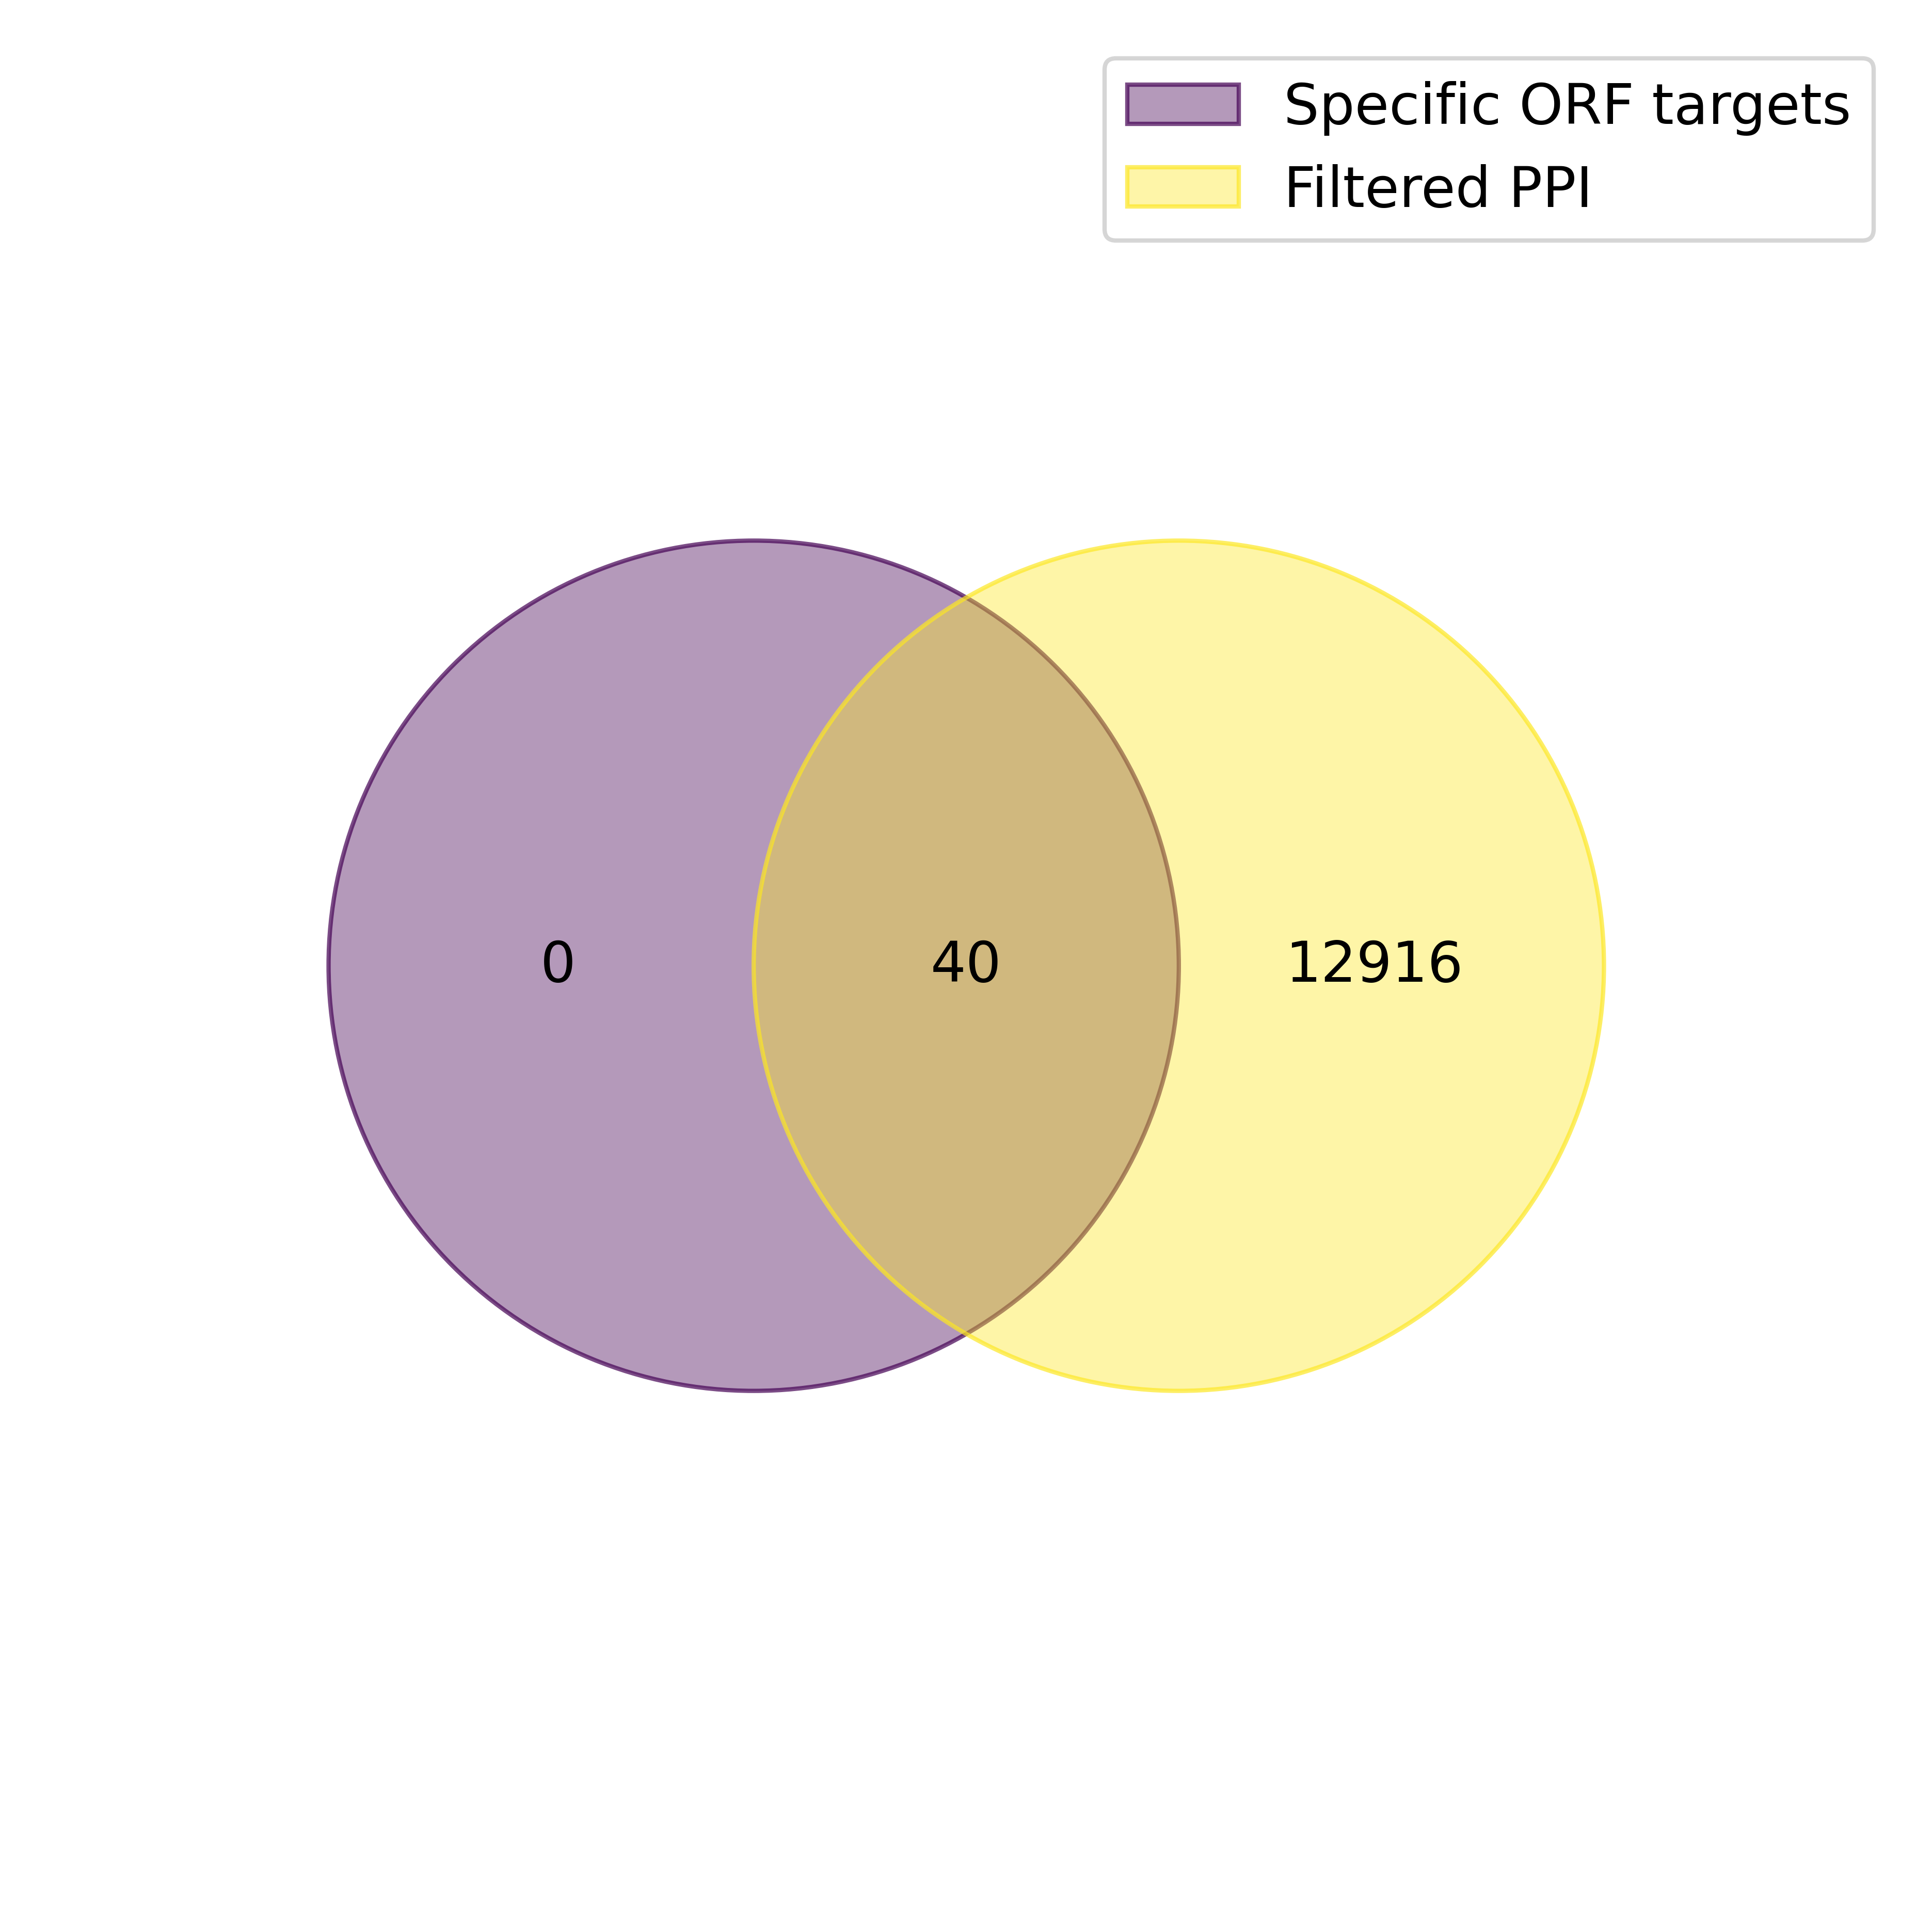

<IPython.core.display.Javascript object>

In [51]:
ax = venn.venn(
    dict(
        zip(
            [
                "Specific ORF targets",
                "Filtered PPI",
            ],
            [
                specific_targets,
                set(filtered_ppi.nodes()),
            ],
        )
    )
)

This network importantly includes all 40 specific ORF target genes that code for proteins.

---

### 3.2. Removing of low-confidence edges

The iRefIndex data base does also contain information regarding the uncertainty of the existance of an edge between any two nodes in form of the so called MIscore.

In the following we will prune the PPI to remove low-confidence edges and respective disconnected components. To this end, we first aim to find a cut-off for the given edge costs that correspond to a measure of uncertainty for the existance of an interaction in the PPI between any pair of nodes.

In [52]:
confidence_cutoff_search_results = search_for_confidence_cutoff(
    filtered_ppi, targets=specific_targets
)

100%|██████████| 1000/1000 [01:43<00:00,  9.63it/s]


<IPython.core.display.Javascript object>

The plots below illustrate the number of nodes, number of edges the average degree and the number of covered specific ORF targets for different cutoff values for the certainty of the respective edges of the subgraph of the human PPI induced by selecting only those gene covered by the scRNA-seq data set.

In [53]:
confidence_cutoff_search_results.loc[
    confidence_cutoff_search_results["n_targets"]
    == np.max(confidence_cutoff_search_results["n_targets"])
].sort_values("cutoff").head(40)

cutoff  n_nodes  n_targets  n_edges  avg_degree
562   0.562    10864         40    54485   10.030376
563   0.563    10864         40    54502   10.033505
564   0.564    10865         40    54504   10.032950
565   0.565    10865         40    54504   10.032950
566   0.566    10927         40    55287   10.119337
567   0.567    10927         40    55287   10.119337
568   0.568    10927         40    55293   10.120436
569   0.569    10927         40    55297   10.121168
570   0.570    10927         40    55297   10.121168
571   0.571    10927         40    55297   10.121168
572   0.572    10936         40    55486   10.147403
573   0.573    10936         40    55510   10.151792
574   0.574    10936         40    55510   10.151792
575   0.575    10936         40    55516   10.152890
576   0.576    10936         40    55516   10.152890
577   0.577    10936         40    55516   10.152890
578   0.578    10936         40    55521   10.153804
579   0.579    10936         40    55521   10.153804
580   0.580    10936         40    55521   10.153804
581   0.581    10936         40    55521   10.153804
582   0.582    10937         40    55546   10.157447
583   0.583    10937         40    55546   10.157447
584   0.584    10937         40    55547   10.157630
585   0.585    10937         40    55547   10.157630
586   0.586    10957         40    56182   10.254997
587   0.587    10957         40    56182   10.254997
588   0.588    10957         40    56183   10.255179
589   0.589    10957         40    56183   10.255179
590   0.590    10958         40    56184   10.254426
591   0.591    10958         40    56184   10.254426
592   0.592    10958         40    56184   10.254426
593   0.593    10958         40    56184   10.254426
594   0.594    10958         40    56184   10.254426
595   0.595    11396         40    66955   11.750614
596   0.596    11396         40    66955   11.750614
597   0.597    11396         40    66955   11.750614
598   0.598    11396         40    66955   11.750614
599   0.599    12662         40   123920   19.573527
600   0.600    12662         40   123920   19.573527
601   0.601    12662         40   123920   19.573527

<IPython.core.display.Javascript object>

We decide to select the cut off such that all 40 specific ORF targets are included and choose the maximum before the steep increase of the number of edges as illustrated in the plots below.

In [54]:
confidence_cutoff = 0.594
cutoff_result = confidence_cutoff_search_results.loc[
    confidence_cutoff_search_results.cutoff == confidence_cutoff
]

<IPython.core.display.Javascript object>

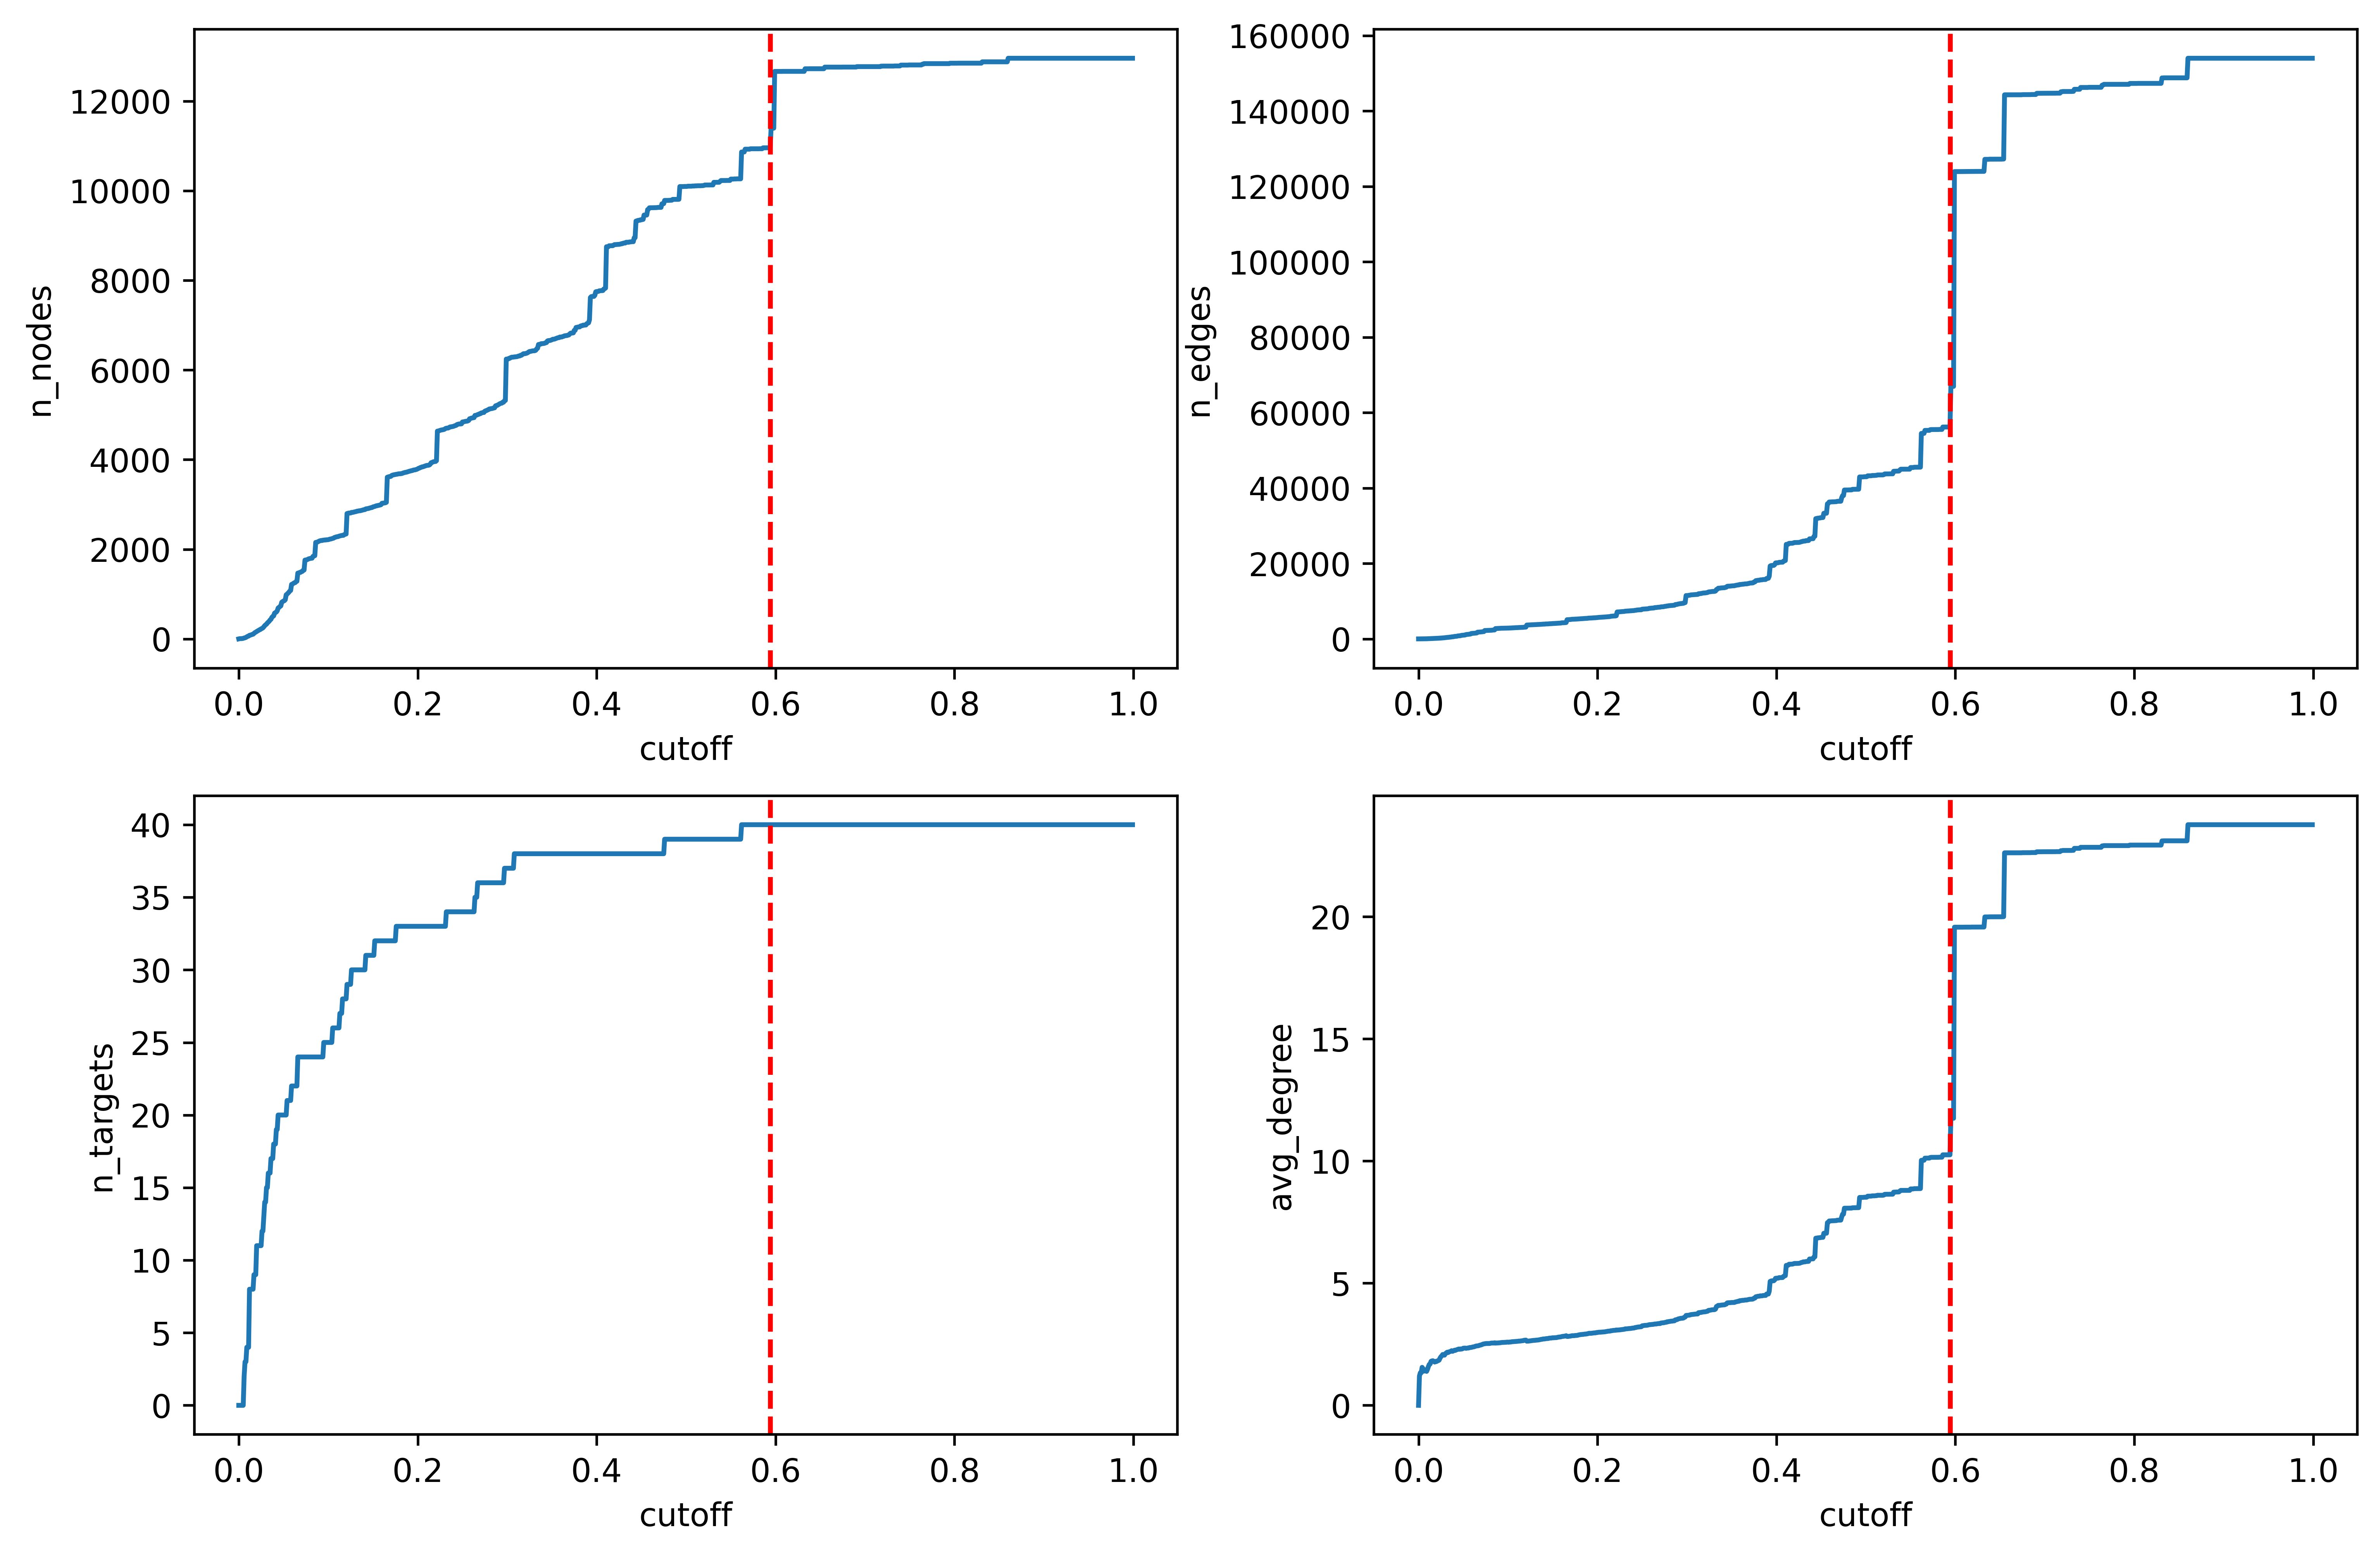

<IPython.core.display.Javascript object>

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[12, 8])
ax = ax.flatten()
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_nodes", ax=ax[0])
ax[0].axvline(x=confidence_cutoff, color="r", linestyle="--")
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_edges", ax=ax[1])
ax[1].axvline(x=confidence_cutoff, color="r", linestyle="--")
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_targets", ax=ax[2])
ax[2].axvline(x=confidence_cutoff, color="r", linestyle="--")
sns.lineplot(
    data=confidence_cutoff_search_results, x="cutoff", y="avg_degree", ax=ax[3]
)
ax[3].axvline(x=confidence_cutoff, color="r", linestyle="--")
plt.show()

<ipython-input-56-b857e9c15d2e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks)


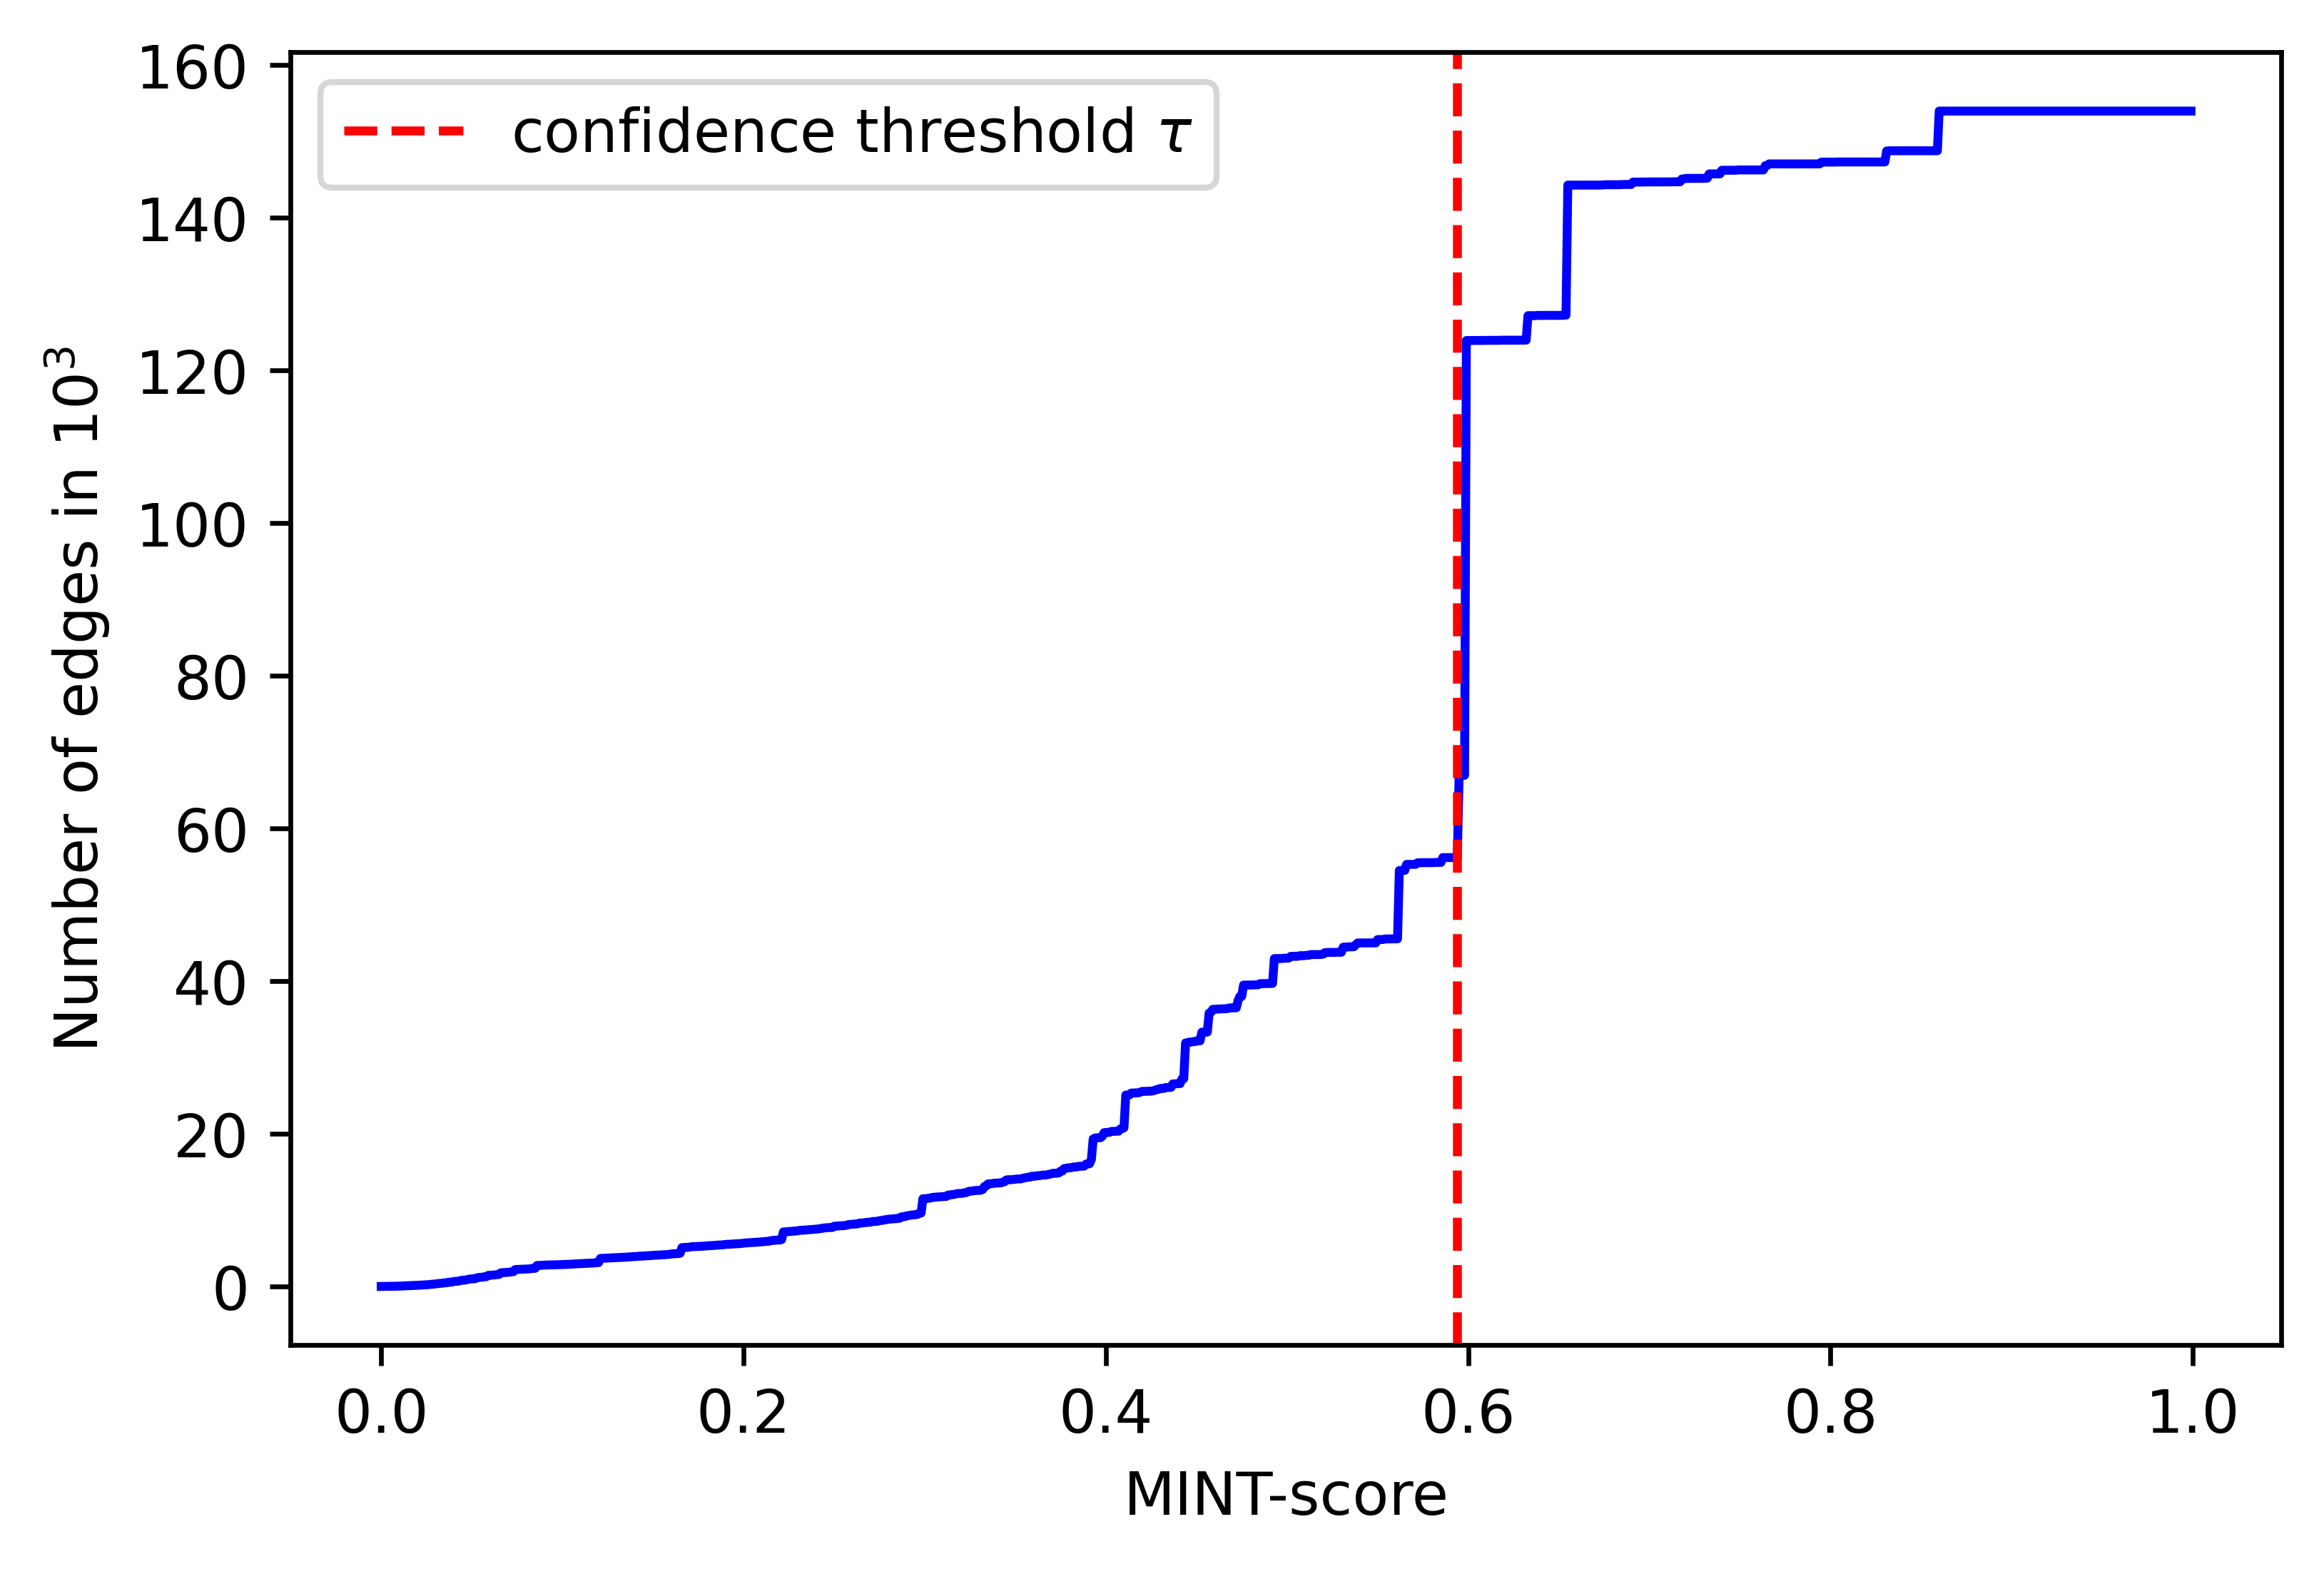

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.lineplot(
    data=confidence_cutoff_search_results, x="cutoff", y="n_edges", ax=ax, color="blue"
)
ticks = np.array(ax.get_yticks() / 1000).astype(int)
ax.set_yticklabels(ticks)
ax.axvline(
    x=confidence_cutoff,
    color="r",
    label=r"confidence threshold $\tau$",
    linestyle="--",
)
ax.set_ylabel(r"Number of edges in $10^3$")
ax.set_xlabel("MINT-score")
ax.legend()
plt.show()

That is the case for a cutoff of 0.594. At this point the induced subgraph consists of 10'864 nodes and 54'485 edges and an average node degree of 10.254.

In [48]:
filtered_ppi_edge_list = nx.to_pandas_edgelist(filtered_ppi)
filtered_ppi_edge_list.loc[:, "mi_score"] = np.array(filtered_ppi_edge_list["cost"])
pruned_ppi = nx.from_pandas_edgelist(
    filtered_ppi_edge_list.loc[filtered_ppi_edge_list["cost"] < confidence_cutoff, :],
    edge_attr="mi_score",
)

<IPython.core.display.Javascript object>

In [49]:
print(pruned_ppi)
print(np.mean(list(dict(pruned_ppi.degree()).values())))

Graph with 10958 nodes and 56184 edges
10.254425990144187


<IPython.core.display.Javascript object>

The pruned PPI consists of 25 connected components. Importantly, all 40 ORF targets are covered in the largest connected component that spans 10'906 nodes and 56'156 edges accounting for an average degree of 10.298.

Number of connected components: 25
Graph named 'Largest connected component' with 10906 nodes and 56156 edges


<ipython-input-50-9e63e3fc1995>:17: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(largest_ccomp))


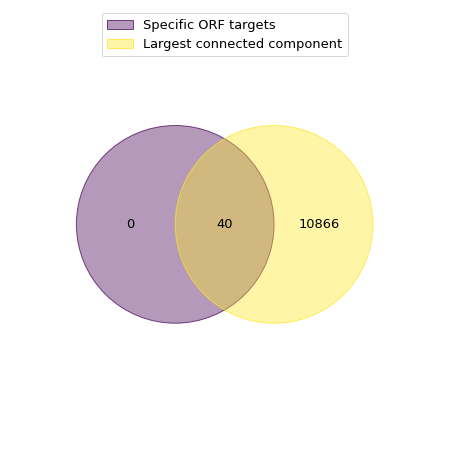

<IPython.core.display.Javascript object>

In [50]:
ccomps = [pruned_ppi.subgraph(c).copy() for c in nx.connected_components(pruned_ppi)]
print("Number of connected components:", len(ccomps))
largest_ccomp = ccomps[0]
largest_ccomp.name = "Largest connected component"
ax = venn.venn(
    dict(
        zip(
            [
                "Specific ORF targets",
                "Largest connected component",
            ],
            [specific_targets, set(largest_ccomp.nodes())],
        )
    ),
    legend_loc="upper center",
)
print(nx.info(largest_ccomp))

Note that the largest connected component still includes all specific ORF targets previously covered by the PPI where we filtered out those genes not in the RNAseq data sets.

We will continue to work with that largest component for the consecutive analyses.

In [51]:
pruned_ppi = largest_ccomp
pruned_ppi.name = "confidence_pruned_ppi"

<IPython.core.display.Javascript object>

---

### 3.3 Remove hub nodes

Next, we will further analyze the network and aim to reduce its connectivity by excluding large hub-nodes that are of less interest for our further analyses and might disguise important indirect links between certain targets.
Thus, let us look at the distribution of the degrees of the nodes in the network.

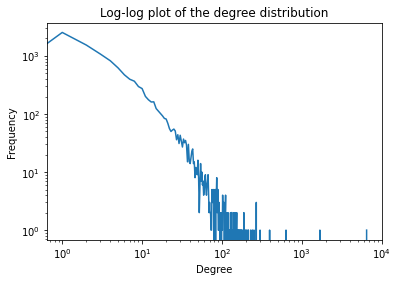

<IPython.core.display.Javascript object>

In [52]:
degree_freq = nx.degree_histogram(pruned_ppi)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Log-log plot of the degree distribution")
plt.show()

We see that there are a few nodes with extreme high degrees. In order to avoid a bias for those nodes in the downstream task of inferring the U2OS specific interactome, we will remove some of such hub nodes from the interactome. This is further motivated by the fact that we would like to emphasize the differences between individual pathways in which our observed ORF targets are included.

In [53]:
degrees_dict = dict(pruned_ppi.degree())
degrees_dict = {
    k: v
    for k, v in sorted(degrees_dict.items(), key=lambda item: item[1], reverse=True)
}
nodes = np.array(list(degrees_dict.keys()))
degrees = np.array(list(degrees_dict.values()))

<IPython.core.display.Javascript object>

To determine an appropriate cutoff of for degree of the nodes to identify those hubnodes that we do not want to take into further consideration, we look at the number of specific ORF targets that are included in the selected gene set, when using different percentile-cutoffs for the node degree.

In [54]:
cutoffs = np.arange(0.9, 1.0, 0.0005)
hub_node_cutoff_screen = run_hub_node_cutoff_analyses(
    pruned_ppi,
    cutoffs=cutoffs,
    targets=specific_targets,
    keep_targets=False,
)

Screen cutoffs: 100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


<IPython.core.display.Javascript object>

In [55]:
hub_node_cutoff_screen.head()

cutoff  n_connected_components  n_nodes_largest_comp  \
0  0.9000                    3919                  5663   
1  0.9005                    3919                  5663   
2  0.9010                    3919                  5663   
3  0.9015                    3919                  5663   
4  0.9020                    3861                  5782   

   n_targets_largest_comp  n_edges_largest_comp  avg_degree_largest_comp  
0                      11                  9257                 3.269292  
1                      11                  9257                 3.269292  
2                      11                  9257                 3.269292  
3                      11                  9257                 3.269292  
4                      11                  9724                 3.363542

<IPython.core.display.Javascript object>

To this end, we will plot the number of connected components, the size of the largest connected component, the number of edges of the largest connected component, the average degree in the largest connected component, the number of all/specific ORF targets in the largest connected component.

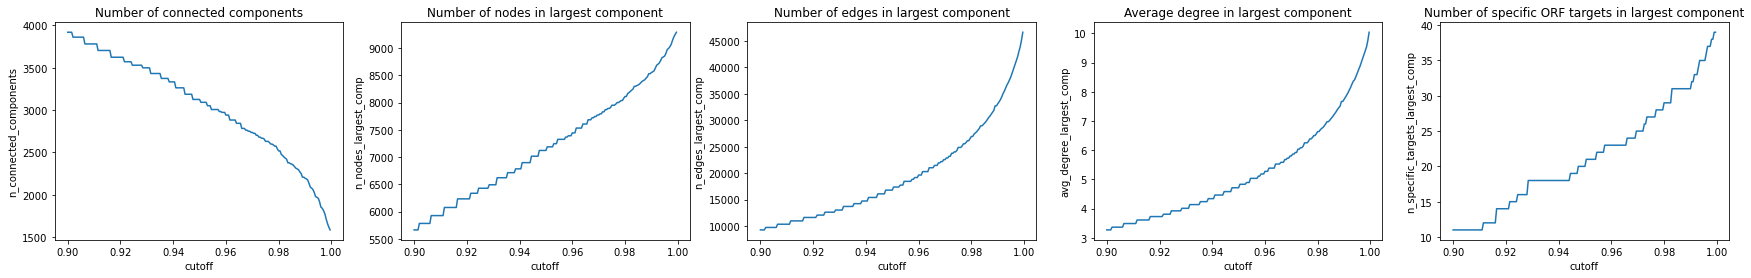

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=[30, 4], nrows=1, ncols=5)
ax = ax.flatten()

ax[0] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_connected_components", ax=ax[0]
)
ax[0].set_title("Number of connected components")

ax[1] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_nodes_largest_comp", ax=ax[1]
)
ax[1].set_title("Number of nodes in largest component")

ax[2] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_edges_largest_comp", ax=ax[2]
)
ax[2].set_title("Number of edges in largest component")

ax[3] = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="avg_degree_largest_comp", ax=ax[3]
)
ax[3].set_title("Average degree in largest component")

ax[4] = sns.lineplot(
    data=hub_node_cutoff_screen,
    x="cutoff",
    y="n_targets_largest_comp",
    ax=ax[4],
)
ax[4].set_ylabel("n_specific_targets_largest_comp")
ax[4].set_title("Number of specific ORF targets in largest component")

plt.show()

In [57]:
hub_node_cutoff_screen.loc[
    hub_node_cutoff_screen["n_targets_largest_comp"]
    == np.max(hub_node_cutoff_screen["n_targets_largest_comp"])
].sort_values("cutoff").head(1)

cutoff  n_connected_components  n_nodes_largest_comp  \
198   0.999                    1620                  9252   

     n_targets_largest_comp  n_edges_largest_comp  avg_degree_largest_comp  
198                      39                 45132                 9.756161

<IPython.core.display.Javascript object>

We see that by removing the top 0.1% of the nodes, the largest component still spans 39/40 specific ORF targets that it possibly can span as CXXC4 is only connected to ubiquitin and thus no longer covered as soon as we prune any hubnode. We will thus conservatively choose to only remove the top 0.1% nodes.

In [58]:
hub_cutoff = np.array(
    hub_node_cutoff_screen.loc[
        hub_node_cutoff_screen["n_targets_largest_comp"]
        == np.max(hub_node_cutoff_screen["n_targets_largest_comp"])
    ]
    .sort_values("cutoff")
    .loc[:, "cutoff"]
)[0]

<IPython.core.display.Javascript object>

In [59]:
degree_cutoff = np.quantile(list(dict(pruned_ppi.degree()).values()), hub_cutoff)
hubnodes = nodes[degrees >= degree_cutoff]
non_hubnodes = nodes[degrees < degree_cutoff]

<IPython.core.display.Javascript object>

In [60]:
for n in hubnodes:
    print("Node:", n, "(", degrees_dict[n], ")")

Node: UBC ( 6477 )
Node: APP ( 1684 )
Node: SUMO2 ( 634 )
Node: TP53 ( 395 )
Node: EGFR ( 300 )
Node: UBE2I ( 269 )
Node: CSNK2A1 ( 269 )
Node: EP300 ( 269 )
Node: SUMO1 ( 252 )
Node: ESR1 ( 242 )
Node: HDAC1 ( 241 )


<IPython.core.display.Javascript object>

The 18 hubnodes that will be filtered out are listed above.

We will now derive the subgraph that only spans the nodes not classified as hubnodes by our previous analyses.

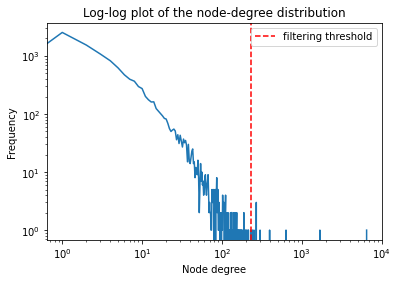

<IPython.core.display.Javascript object>

In [68]:
fig = plt.figure()
degree_freq = nx.degree_histogram(pruned_ppi)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq)
plt.xlabel("Node degree")
plt.ylabel("Frequency")
plt.title("Log-log plot of the node-degree distribution")
plt.axvline(x=degree_cutoff, label="filtering threshold", c="red", linestyle="--")
plt.legend()
plt.show()

Importantly, the subgraph induced by removing the identified hubnodes from the network does not remain fully connected and importantly one of the ORF targets that was shown to yield a specific structural phenotype upon overexpression becomes disconnected from the largest connected component that spans all other ORF targets.

In [157]:
selected_ppi = nx.Graph(pruned_ppi.subgraph(non_hubnodes))
selected_ppi.name = "confidence_hub_pruned_ppi"

<IPython.core.display.Javascript object>

Note that we will also save a version of the graph that only excludes the top two hubnodes which corresponds to choosing the elbow of the degree distribution to exclude the hubnodes. We will store the subgraph of the confidence pruned and of the filtered PPI respectively. The latter being an even more conservative selection of the PPI.

In [158]:
ccomps = [
    selected_ppi.subgraph(c).copy() for c in nx.connected_components(selected_ppi)
]
for comp in ccomps:
    if len(specific_targets.intersection(comp.nodes())) > 0:
        print(nx.info(comp))
        print(specific_targets.intersection(comp.nodes()))

Graph named 'confidence_hub_pruned_ppi' with 9252 nodes and 45132 edges
{'ATF4', 'MAP3K5', 'TSC2', 'PRKCE', 'SMO', 'SRC', 'BCL2L11', 'ERG', 'BAX', 'RHOA', 'GLI1', 'FGFR3', 'SMAD4', 'HRAS', 'DIABLO', 'WWTR1', 'TRAF2', 'ELK1', 'BRAF', 'PIK3R2', 'RELB', 'FOXO1', 'CDC42', 'JUN', 'MAP3K9', 'MAP3K2', 'RAF1', 'CASP8', 'CREB1', 'MYD88', 'SREBF1', 'E2F1', 'CEBPA', 'MAPK7', 'MAP2K3', 'PRKACA', 'AKT1S1', 'CDKN1A', 'IRAK4'}
Graph named 'confidence_hub_pruned_ppi' with 1 nodes and 0 edges
{'CXXC4'}


<ipython-input-158-f396937f9551>:6: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(comp))


<IPython.core.display.Javascript object>

In [159]:
selected_ppi = ccomps[0]

<IPython.core.display.Javascript object>

The induced subgraph spans 9,252 nodes including all 39/40 specific ORF targets with an average degree of 10.88 stemming from 45,132 edges. This includes 819 L1000 genes.

In [160]:
print(selected_ppi)

Graph named 'confidence_hub_pruned_ppi' with 9252 nodes and 45132 edges


<IPython.core.display.Javascript object>

---

## 4. Relationship strength of the between the selected genes

In this section we will look at ways to define the edge costs for the Prize-collecting Steiner tree inference-based derivation of the U2OS-specific interactome. To this end, we will look at three different measures that are often used to describe the association of genes to guide the derivation of regulatory networks and interactomes, namely the Pearson correlation, the Spearman correlation and the normalized mutual information. Since, we want to assign higher costs to for relationships between any pair of genes that we have little evidence for as measured by the three previously mentioned metrics, we compute these as

$$
w_{i,j} = 1-|a_{i,j}|,
$$

where $w_{i,j}$ is the edge weight and $a_{i,j}$ is the respective association of the genes $i$ and $j$ as measured by the metrics.

We will now compute the respective edge weights for any edge in the base PPI and visualize their distribution.

In [161]:
selected_ppi = compute_edge_weights(
    selected_ppi,
    fucci_data,
    metrics=["pearsonr", "spearmanr", "pearsonp", "spearmanp"],
    attr_name="scgex",
)

Compute edge weights for spearmanp: 100%|██████████| 45132/45132 [00:27<00:00, 1657.50it/s]


<IPython.core.display.Javascript object>

### 4.1. Pearson correlation-based edge weights

In [162]:
scgex_pearsonr_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "scgex_pearsonr").values())
)

<IPython.core.display.Javascript object>

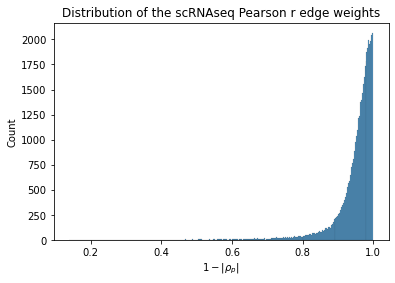

<IPython.core.display.Javascript object>

In [166]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.histplot(scgex_pearsonr_weights, ax=ax)
ax.set_title("Distribution of the scRNAseq Pearson r edge weights")
ax.set_xlabel(r"$1-|\rho_p|$")
plt.show()

### 4.2. Spearman correlation-based edge weights

In [165]:
scgex_spearmanr_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "scgex_spearmanr").values())
)

<IPython.core.display.Javascript object>

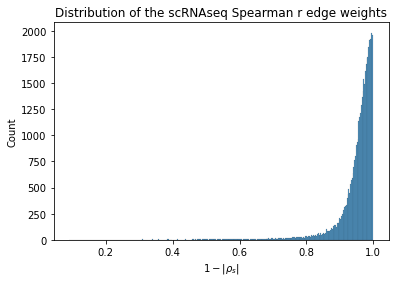

<IPython.core.display.Javascript object>

In [169]:
fig, ax = plt.subplots(figsize=[6, 4], ncols=1)
ax = sns.histplot(scgex_spearmanr_weights, ax=ax)
ax.set_title("Distribution of the scRNAseq Spearman r edge weights")
ax.set_xlabel(r"$1-|\rho_s|$")
plt.show()

----

## 5. PCST preprocessing

After having computed the respective metrics we will now construct different version of the PPI with associated edge weights and node prizes for the inference of the PCST algorithm.

We decide to choose the absolute log fold-change as the the prizes associated with each node, but in order to ensure that the PCST algorithm will select the specific ORF targets we assign a prize to all of those targets that is equal to the maximum absolute log-fold change among the nodes in the network.

We decide to set the edge weights as $1-|r_{spearman}|$ computed from the scRNA-seq data set as in contrast to the Pearson correlation it can also capture non-linear relationships and has been shown to perform on par with more sophisticated measures in network inference tasks in several other work.

In [170]:
ppi_name = "ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv"

<IPython.core.display.Javascript object>

In [171]:
prepared_ppi = selected_ppi.copy()
prepared_ppi.name = ppi_name
abs_log_fc = marker_results.loc[:, "abs_log_fc"]

## Set node prizes
for node in prepared_ppi.nodes(data=True):
    if node[0] in specific_targets:
        node[-1]["ccle_abslogfc"] = np.max(abs_log_fc)
    else:
        try:
            node[-1]["ccle_abslogfc"] = abs_log_fc[node[0]]
        except KeyError:
            node[-1]["ccle_abslogfc"] = 0

<IPython.core.display.Javascript object>

In [187]:
## Save network
nx.write_gpickle(
    prepared_ppi, "../../../data/ppi/preprocessing/{}.pkl".format(ppi_name)
)

<IPython.core.display.Javascript object>

---

## 6. Analyses of the PCST preprocessed graphs

To get a better understanding of the input graphs that we constructed for the PCST driven inference we will plot some basic characteristics of the input graph. For that we will first focus on the 3rd version that we constructed for which the edge weights are given by $1-|r_{Spearman}|$ and the prizes by the absolute log fold-change with the ones of the ORF targets constantly set to the maximum log fold-change.

In [175]:
prizes = dict(nx.get_node_attributes(prepared_ppi, "ccle_abslogfc"))
costs = dict(nx.get_edge_attributes(prepared_ppi, "scgex_spearmanr"))

<IPython.core.display.Javascript object>

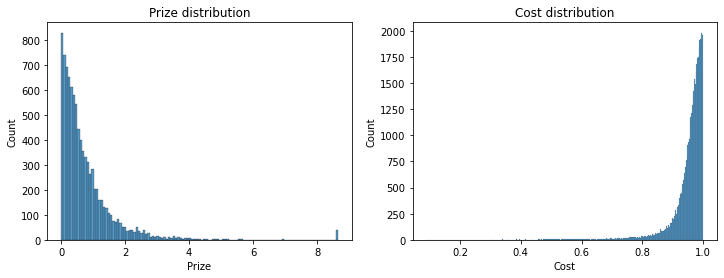

<IPython.core.display.Javascript object>

In [176]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.histplot(prizes.values(), ax=ax[0], legend=False)
ax[0].set_title("Prize distribution")
ax[0].set_xlabel("Prize")
ax[1] = sns.histplot(costs.values(), ax=ax[1], legend=False)
ax[1].set_title("Cost distribution")
ax[1].set_xlabel("Cost")
plt.show()
plt.show()

We are now interested if there is a relationship between the prizes and edge costs and the corresponding nodes i.e. those that the edges associated with the costs connect to. To this end, we will plot the prizes by the corresponding edge degree and as well as the edge costs.

In [178]:
degrees = dict(prepared_ppi.degree())
degrees = {k: v for k, v in sorted(degrees.items())}
prizes = {k: v for k, v in sorted(prizes.items())}
orf_target_colors = []
for k in prizes:
    orf_target_colors.append(k in specific_targets)

<IPython.core.display.Javascript object>

In [179]:
mean_node_cost = []
std_node_cost = []
node_degrees = []
node_orf_target_colors = []
for node in prepared_ppi.nodes():
    node_orf_target_colors.append(node in specific_targets)
    node_degrees.append(prepared_ppi.degree(node))
    edges = prepared_ppi.edges(node, data=True)
    node_cost = []
    for edge in edges:
        node_cost.append(edge[-1]["scgex_spearmanr"])
    mean_node_cost.append(np.mean(node_cost))
    std_node_cost.append(np.std(node_cost))

<IPython.core.display.Javascript object>

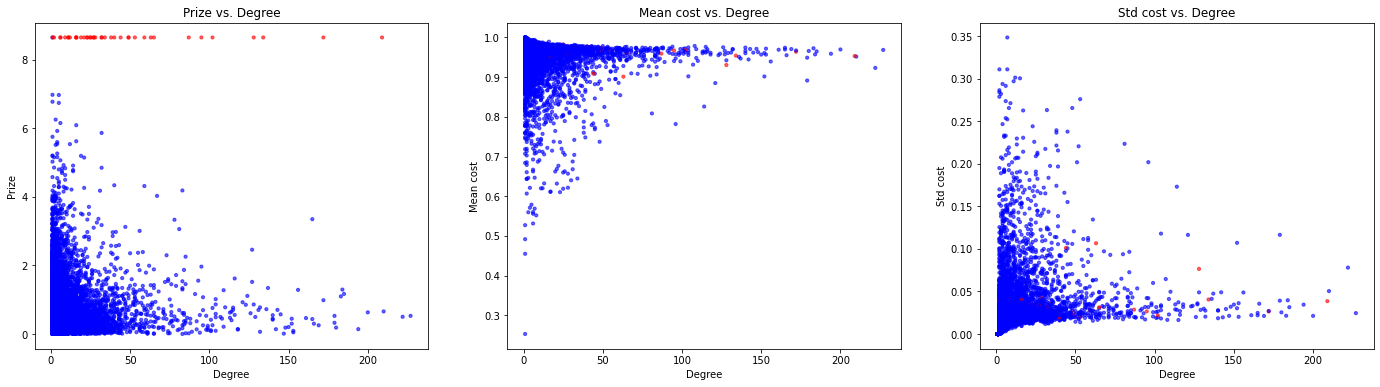

<IPython.core.display.Javascript object>

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[24, 6])
ax = ax.flatten()
ax[0].scatter(
    degrees.values(),
    prizes.values(),
    c=orf_target_colors,
    s=10,
    cmap="bwr",
    alpha=0.6,
)
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Prize")
ax[0].set_title("Prize vs. Degree")

ax[1].scatter(
    node_degrees, mean_node_cost, c=node_orf_target_colors, s=10, cmap="bwr", alpha=0.6
)
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Mean cost")
ax[1].set_title("Mean cost vs. Degree")

ax[2].scatter(
    node_degrees, std_node_cost, c=node_orf_target_colors, s=10, cmap="bwr", alpha=0.6
)
ax[2].set_xlabel("Degree")
ax[2].set_ylabel("Std cost")
ax[2].set_title("Std cost vs. Degree")
plt.show()

The above plots illustrate that the most of nodes with a very high degree get relatively low yet non-zero prizes. Note, that due to the manual inflation of the prizes for the specific ORF targets that does not apply to those (marked in red). Additionally, most nodes with high-degrees are connected to many high cost edges as shown by the mean cost. Recalling the histogram of the overall edge cost distribution this is not surprising. The variance of the edge cost also decreases with increasing degree on average.

Jointly, this suggest that we might want to exclude even more high-degree nodes. However, this will also likely cause the largest connected component of the induced subgraph to span less of the specific ORF targets. Thus, it would be important to either manually include these as long as they can be connected to the largest connected component or that the specific ORF targets that are filtered out are of no special interest for the downstream analyses.